# <span style="color:green"> Numerical Simulation Laboratory </span>
## <span style="color:brown"> Python Exercise 12 </span>
## <span style="color:orange"> Keras - Deep & Convolutional Neural Network image recognition </span>

### MNIST with Keras

The goal of exercise 12 is to use deep neural network models, implemented in the Keras python package, to recognize and distinguish between the ten handwritten digits (0-9).

The MNIST dataset comprises $70000$ handwritten digits, each of which comes in a square image, divided into a $28\times 28$ pixel grid. Every pixel can take on $256$ gradation of the gray color, interpolating between white and black, and hence each data point assumes any value in the set $\{0,1,\dots,255\}$. Since there are $10$ categories in the problem, corresponding to the ten digits, this problem represents a generic **classification task**. 

In [1]:
#import os
#os.environ['KMP_DUPLICATE_LIB_OK']='True' #This is needed in my Anaconda+MacOsX installation; leave it commented.
import tensorflow as tf
from tensorflow import keras
import os
import numpy as np
import matplotlib.pyplot as plt
seed=0
np.random.seed(seed) # fix random seed
tf.random.set_seed(seed)

2023-10-31 21:35:03.515189: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-10-31 21:35:03.516748: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-31 21:35:03.540090: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-10-31 21:35:03.540116: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-10-31 21:35:03.540138: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to regi

#### Step 1: Load and Process the Data

Keras can conveniently download the MNIST data from the web. All we need to do is import the `mnist` module and use the `load_data()` class, and it will create the training and test data sets or us.

The MNIST set has pre-defined test and training sets, in order to facilitate the comparison of the performance of different models on the data.

Once we have loaded the data, we need to format it in the correct shape.

In [2]:
from keras.datasets import mnist

# input image dimensions
img_rows, img_cols = 28, 28 # number of pixels 
# output
num_classes = 10 # 10 digits

# the data, split between train and test sets
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()

print('X_train shape:', X_train.shape)
print('Y_train shape:', Y_train.shape)

X_train shape: (60000, 28, 28)
Y_train shape: (60000,)


#### Example: to_categorical

Converts a class vector (integers) to binary class matrix. E.g. for use with categorical_crossentropy.

In [3]:
# Consider an array of 5 labels out of a set of 3 classes {0, 1, 2}:
labels = np.array([0, 2, 1, 2, 0])
# `to_categorical` converts this into a matrix with as many columns as there are classes.
# The number of rows stays the same.
keras.utils.to_categorical(labels)

array([[1., 0., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 0., 1.],
       [1., 0., 0.]], dtype=float32)

#### Reshape data and convert labels to be used with categorical cross entropy

X_train shape: (60000, 784)
X_test shape: (10000, 784)

an example of a data point with label 4


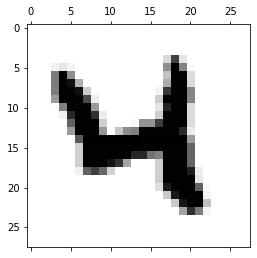

... and with label [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.] after to_categorical

X_train shape: (60000, 784)
Y_train shape: (60000, 10)


In [4]:
# reshape data, it could depend on Keras backend
X_train = X_train.reshape(X_train.shape[0], img_rows*img_cols)
X_test = X_test.reshape(X_test.shape[0], img_rows*img_cols)
print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)
print()

# cast to floats
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

# rescale data in interval [0,1]
X_train /= 255
X_test /= 255

# look at an example of data point
print('an example of a data point with label', Y_train[20])
# matshow: display a matrix in a new figure window
plt.matshow(X_train[20,:].reshape(28,28),cmap='binary')
plt.show()

# convert class vectors to binary class matrices, e.g. for use with categorical_crossentropy
Y_train = keras.utils.to_categorical(Y_train, num_classes)
Y_test = keras.utils.to_categorical(Y_test, num_classes)
print('... and with label', Y_train[20], 'after to_categorical')
print()
print('X_train shape:', X_train.shape)
print('Y_train shape:', Y_train.shape)

#### Step 2: Define the Neural Net and its Architecture

We can now move on to construct our deep neural net. We shall use Keras's `Sequential()` class to instantiate a model, and will add different deep layers one by one using the `add()` method

For the purposes of our example, it suffices to focus on `Dense` layers for simplicity. Every `Dense()` layer accepts as its first required argument an integer which specifies the number of neurons. The type of activation function for the layer is defined using the `activation` optional argument, the input of which is the name of the activation function in `string` format. Examples include `relu`, `tanh`, `elu`, `sigmoid`, `softmax`. 

In order for our DNN to work properly, we have to make sure that the numbers of input and output neurons for each layer match. Therefore, we specify the shape of the input in the first layer of the model explicitly using the optional argument `input_shape=(N_features,)`. The sequential construction of the model then allows Keras to infer the correct input/output dimensions of all hidden layers automatically. Hence, we only need to specify the size of the softmax output layer to match the number of categories.

In [5]:
from keras.models import Sequential
from keras.layers import Dense, Dropout

def create_DNN():
    # instantiate model
    model = Sequential()
    # add a dense all-to-all relu layer
    model.add(Dense(400,input_shape=(img_rows*img_cols,), activation='relu'))
    # add a dense all-to-all relu layer
    model.add(Dense(100, activation='relu'))
    # apply dropout with rate 0.5
    model.add(Dropout(0.5))
    # soft-max layer
    model.add(Dense(num_classes, activation='softmax'))
    
    return model

print('Model architecture created successfully!')

Model architecture created successfully!


#### Step 3: Choose the Optimizer and the Cost Function

Next, we choose the loss function according to which to train the DNN. For classification problems, this is the cross entropy, and since the output data was cast in categorical form, we choose the `categorical_crossentropy` defined in Keras' `losses` module. Depending on the problem of interest one can pick any other suitable loss function. To optimize the weights of the net, we choose SGD. This algorithm is already available to use under Keras' `optimizers` module, but we could use any other built-in one as well. The parameters for the optimizer, such as `lr` (learning rate) or `momentum` are passed using the corresponding optional arguments of the `SGD()` function. All available arguments can be found in Keras' online documentation at [https://keras.io/](https://keras.io/). While the loss function and the optimizer are essential for the training procedure, to test the performance of the model one may want to look at a particular `metric` of performance. For instance, in categorical tasks one typically looks at their `accuracy`, which is defined as the percentage of correctly classified data points. To complete the definition of our model, we use the `compile()` method, with optional arguments for the `optimizer`, `loss`, and the validation `metric` as follows:

In [6]:
from keras.optimizers import SGD, Adam, RMSprop, Adagrad, Adadelta, Adam, Adamax, Nadam

def compile_model():
    # create the model
    model=create_DNN()
    # compile the model
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=SGD(),
                  metrics=['acc'])
    return model

print('Model compiled successfully and ready to be trained.')

Model compiled successfully and ready to be trained.


#### Step 4: Train the model

We train our DNN in minibatches. 

Shuffling the training data during training improves stability of the model. Thus, we train over a number of training epochs. Each epoch corresponds to using **all the train data** divided in minibatches.

Training the DNN is a one-liner using the `fit()` method of the `Sequential` class. The first two required arguments are the training input and output data. As optional arguments, we specify the mini-`batch_size`, the number of training `epochs`, and the test or `validation_data`. To monitor the training procedure for every epoch, we set `verbose=True`. 

In [7]:
# training parameters
batch_size = 32
epochs = 5

# create the deep neural net
model_DNN = compile_model()

# train DNN and store training info in history
history = model_DNN.fit(X_train, Y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(X_test, Y_test))

2023-10-31 21:35:06.225847: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-10-31 21:35:06.226268: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2211] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Epoch 1/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.7576 - acc: 0.7733 - val_loss: 0.3116 - val_acc: 0.9142
Epoch 2/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.3841 - acc: 0.8905 - val_loss: 0.2379 - val_acc: 0.9303
Epoch 3/5
1875/1875 [==============================] - 3s 2ms/step - loss: 0.3101 - acc: 0.9122 - val_loss: 0.2008 - val_acc: 0.9394
Epoch 4/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2674 - acc: 0.9256 - val_loss: 0.1756 - val_acc: 0.9463
Epoch 5/5
1875/1875 [==============================] - 3s 2ms/step - loss: 0.2377 - acc: 0.9323 - val_loss: 0.1611 - val_acc: 0.9512


#### Step 5: Evaluate the Model Performance on the *Unseen* Test Data

Next, we evaluate the model and read of the loss on the test data, and its accuracy using the `evaluate()` method.

313/313 [==============================] - 0s 1ms/step - loss: 0.1611 - acc: 0.9512

Test loss: 0.16108247637748718
Test accuracy: 0.951200008392334


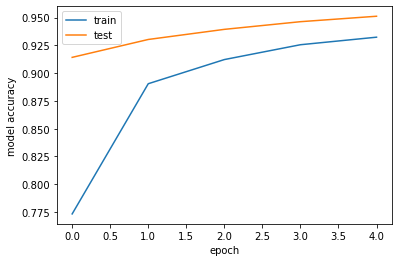

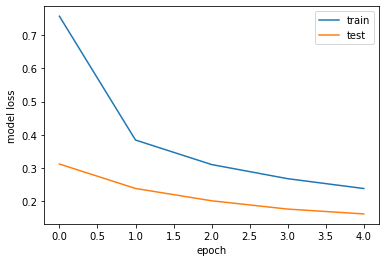

In [8]:
# evaluate model
score = model_DNN.evaluate(X_test, Y_test, verbose=1)

# print performance
print()
print('Test loss:', score[0])
print('Test accuracy:', score[1])

# look into training history

# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.ylabel('model accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('model loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()

Dropout, during training, slices off some artificial neurons, thus, training accuracy suffers.

Dropout, during testing, turns itself off and allows all of the ‘weak classifiers’ in the neural network to be used. Thus, testing accuracy improves with respect to training accuracy.

313/313 [==============================] - 0s 1ms/step


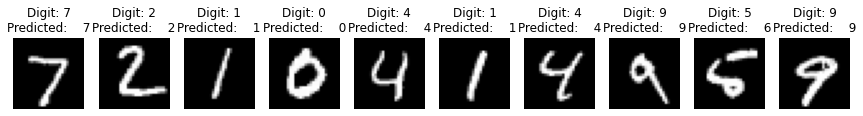

In [9]:
#X_test = X_test.reshape(X_test.shape[0], img_rows*img_cols)
predictions = model_DNN.predict(X_test)

X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols,1)

plt.figure(figsize=(15, 15)) 
for i in range(10):    
    ax = plt.subplot(2, 10, i + 1)    
    plt.imshow(X_test[i, :, :, 0], cmap='gray')    
    plt.title("Digit: {}\nPredicted:    {}".format(np.argmax(Y_test[i]), np.argmax(predictions[i])))    
    plt.axis('off') 
plt.show()

### Exercise 12.1

<span style="color:red">Change at will and train your DNN by increasing the number of epochs to an adeuqate value</span>. Try to use at least two other optimizers, different from SGD: <span style="color:red">watch to accuracy and loss for training and validation data and comment on the performances</span>.

In [10]:
###########################################################################
######### THE COMPLETE COMMENTED SOLUTION IS AFTER THE ASSIGNMENT #########
###########################################################################

#### Creating Convolutional Neural Nets with Keras

We have so far considered each MNIST data sample as a $(28\times 28,)$-long 1d vector. On the other hand, we do know that in every one of the hand-written digits there are *local* spatial correlations between the pixels, but also *translational invariance*, which we would like to take advantage of to improve the accuracy of our classification model. To this end, we first need to reshape the training and test input data as follows

In [11]:
# you will need the following for Convolutional Neural Networks
from keras.layers import Flatten, Conv2D, MaxPooling2D

# reshape data, depending on Keras backend
if keras.backend.image_data_format() == 'channels_first':
    X_train = X_train.reshape(X_train.shape[0], 1, img_rows, img_cols)
    X_test = X_test.reshape(X_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
    X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)
    
print('X_train shape:', X_train.shape)
print('Y_train shape:', Y_train.shape)
print()
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

X_train shape: (60000, 28, 28, 1)
Y_train shape: (60000, 10)

60000 train samples
10000 test samples


One can ask the question of whether a neural net can learn to recognize such local patterns. This can be achieved by using convolutional layers.

### Exercise 12.2

Change the architecture of your DNN using convolutional layers. Use `Conv2D`, `MaxPooling2D`, `Dropout`, but also do not forget `Flatten`, a standard `Dense` layer and `soft-max` in the end. I have merged step 2 and 3 in the following definition of `create_CNN()` that **<span style="color:red">you should complete</span>**:

In [12]:
###########################################################################
######### THE COMPLETE COMMENTED SOLUTION IS AFTER THE ASSIGNMENT #########
###########################################################################

def create_CNN():
    # instantiate model
    model = Sequential()
    # add first convolutional layer with 10 filters (dimensionality of output space)
    model.add(Conv2D(10, kernel_size=(5, 5),
                     activation='relu',
                     input_shape=input_shape))

    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Conv2D(16, kernel_size=(3, 3),
                     activation='relu',
                     input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Flatten())
    model.add(Dropout(0.15))
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.15))
    model.add(Dense(50, activation='relu'))

    model.add(Dense(10, activation='softmax'))  # Output layer
    
    # compile the model
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer='SGD',
                  metrics=['acc'])
    return model

Train your DCNN and evaluate its performance proceeding exactly as before:

In [13]:
# training parameters
batch_size = 32
epochs = 20 # INSERT HERE AN ADEQUATE NUMBER OF EPOCHS!

# create the deep conv net
model_CNN=create_CNN()

# train CNN
history = model_CNN.fit(X_train, Y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(X_test, Y_test))

# evaliate model
score = model_CNN.evaluate(X_test, Y_test, verbose=1)

# print performance
print()
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Epoch 1/20
1875/1875 [==============================] - 6s 3ms/step - loss: 0.7488 - acc: 0.7542 - val_loss: 0.1676 - val_acc: 0.9514
Epoch 2/20
1875/1875 [==============================] - 5s 3ms/step - loss: 0.2137 - acc: 0.9332 - val_loss: 0.1030 - val_acc: 0.9688
Epoch 3/20
1875/1875 [==============================] - 5s 3ms/step - loss: 0.1527 - acc: 0.9526 - val_loss: 0.0783 - val_acc: 0.9735
Epoch 4/20
1875/1875 [==============================] - 5s 3ms/step - loss: 0.1290 - acc: 0.9596 - val_loss: 0.0644 - val_acc: 0.9778
Epoch 5/20
1875/1875 [==============================] - 5s 3ms/step - loss: 0.1134 - acc: 0.9650 - val_loss: 0.0602 - val_acc: 0.9807
Epoch 6/20
1875/1875 [==============================] - 5s 3ms/step - loss: 0.1010 - acc: 0.9681 - val_loss: 0.0530 - val_acc: 0.9830
Epoch 7/20
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0924 - acc: 0.9720 - val_loss: 0.0476 - val_acc: 0.9840
Epoch 8/20
1875/1875 [==============================] - 5s 3ms

In the end, **<span style="color:red">add the evaluation of your CNN performances</span>** like that used for the DNN.

### Exercise 12.3

Use the `gimp` application to create 10 pictures of your "handwritten" digits, import them in your jupyter-notebook and try to see if your CNN is able to recognize your handwritten digits.

For example, you can use the following code to import a picture of an handwritten digit
(Note: you should install Python Image Library (PIL/Pillow):

In [14]:
###########################################################################
######### THE COMPLETE COMMENTED SOLUTION IS AFTER THE ASSIGNMENT #########
###########################################################################

In [15]:
from PIL import Image
import os

Image size: 28x28


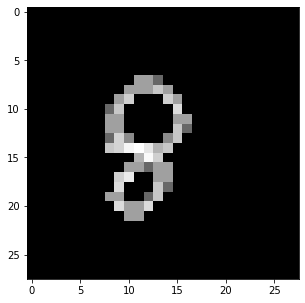

(28, 28)


In [16]:
digit_filename = "./imgs/CNN/digit8.png" # I substituted my digit so that it compiles
digit_in = Image.open(digit_filename).convert('L')

ydim, xdim = digit_in.size
print("Image size: "+str(xdim)+"x"+str(ydim))
pix=digit_in.load();
data = np.zeros((xdim, ydim))
for j in range(ydim):
    for i in range(xdim):
        data[i,j]=pix[j,i]

data /= 255

plt.figure(figsize=(5,5))
plt.imshow(data, cmap='gray')
plt.show()

print(data.shape)

I use the previously trained DNN to predict the digit:

(28, 28)
(1, 784)
1/1 [==============================] - 0s 12ms/step


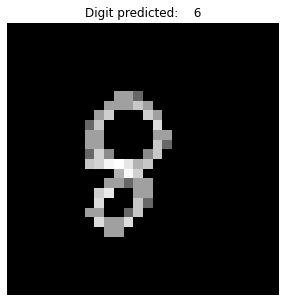

In [17]:
print(data.shape)
data = data.reshape(1,xdim*ydim)
print(data.shape)
pred_0 = model_DNN.predict(data)

data = data.reshape(xdim,ydim)

plt.figure(figsize=(5, 5))  
plt.imshow(data, cmap='gray')    
plt.title("Digit predicted:    {}".format(np.argmax(pred_0)))
plt.axis('off') 
plt.show()

### <span style="color:green">Supplementary information 1: Use of `gimp` </span>

- from the Unix shell type: `gimp` and hit `Return`
- File -> new (chose: 28x28 pixels)
- rascale the image to 800%
- Use the **brush** with dimension 2px to draw your digit
- Color -> invert (to have black background)
- Export the image as a `.png` file

That's all!

### <span style="color:green">Supplementary information 2: Display trained filters in your CNN</span>

Print your NN layers:

In [18]:
layer_index=0
for layer in model_CNN.layers:
    print(layer_index, layer.name)
    layer_index+=1

0 conv2d
1 max_pooling2d
2 conv2d_1
3 max_pooling2d_1
4 flatten
5 dropout_1
6 dense_3
7 dropout_2
8 dense_4
9 dense_5


Display your filters:

(5, 5, 1, 10)


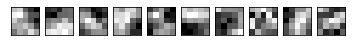

In [19]:
# layer_index should be the index of a convolutional layer
layer_index=0
# retrieve weights from the convolutional hidden layer
filters, biases = model_CNN.layers[layer_index].get_weights()
# normalize filter values to 0-1 so we can visualize them
f_min, f_max = filters.min(), filters.max()
filters = (filters - f_min) / (f_max - f_min)
print(filters.shape)

# plot filters
n_filters, ix = filters.shape[3], 1
for i in range(n_filters):
    # get the filter
    f = filters[:, :, :, i]
    # specify subplot and turn of axis
    ax = plt.subplot(1,n_filters, ix)
    ax.set_xticks([])
    ax.set_yticks([])
    # plot filter channel in grayscale
    plt.imshow(f[:, :, 0], cmap='gray')
    ix += 1
# show the figure
plt.show()

### <span style="color:green">Supplementary information 3: Monitor layer outputs in your CNN</span>

In [20]:
test_index = 0

from keras.models import Model
layer_outputs = [layer.output for layer in model_CNN.layers]
activation_model = Model(inputs=model_CNN.input, outputs=layer_outputs)
activations = activation_model.predict(X_test[test_index].reshape(1,28,28,1))
 
def display_activation(activations, col_size, row_size, layer_index): 
    activation = activations[layer_index]
    activation_index=0
    fig, ax = plt.subplots(row_size, col_size, figsize=(row_size*3,col_size*3))
    for row in range(0,row_size):
        for col in range(0,col_size):
            ax[row][col].imshow(activation[0, :, :, activation_index], cmap='gray')
            activation_index += 1

1/1 [==============================] - 0s 70ms/step


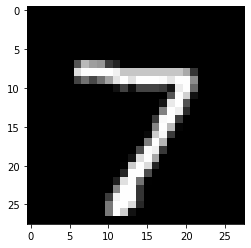

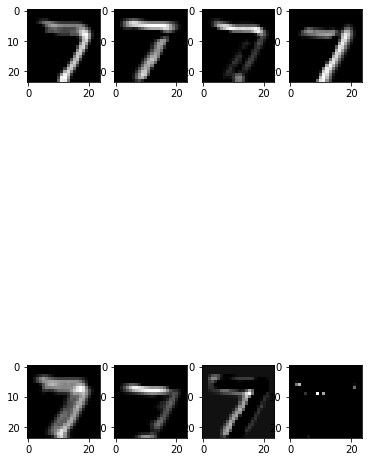

In [21]:
%matplotlib inline
plt.imshow(X_test[test_index][:,:,0], cmap='gray')
# def display_activation(activations, col_size, row_size, layer number)
display_activation(activations, 4, 2, 0)
# col_size x row_size must be <= Number of filters for the convolutional layer

# 
# 
# 

# <span style="color:darkred"> SOLUTION </span>

### <span style="color:darkblue"> Exercise 12.1 </span>

#### SGD

In order to improve the learning process, I will train my DNNs for 20 epochs. Therefore, the first thing I am going to do is simply to extend the training of the NN given as an exemple to 20 epochs. Then I will compare the differences in performance of different models.
I found a final training accuracy of 0.9738 and a final test accuracy of 0.9758.
The data on accuracy and loss as functions of training epoch are plotted in the figures below. At the end the results of a sample classification are shown.

<img src="./imgs/DNN/sgd_acc.png?version=2">
<img src="./imgs/DNN/sgd_loss.png?version=2">
<img src="./imgs/DNN/sgd_samples.png?version=2">

#### Adam

Now I will do the same for a few more optimization methods.
Possibilities are SGD, Adam, RMSprop, Adagrad, Adadelta, Adam, Adamax, Nadam.
First I will try the adaptive moment estimation (Adam), since I already used it in LSN Exercise 11.

For Adam I found a final training accuracy of 0.9948 and a final test accuracy of 0.9813. They are both better results than what was found with SGD. However the curves of the test accuracy and loss function show an irregular behaviour as the epochs go on. The trend of growth of the loss function might indicate that some overfitting is being done through this optimization method.

<img src="./imgs/DNN/adam_acc.png">
<img src="./imgs/DNN/adam_loss.png">
<img src="./imgs/DNN/adam_samples.png">

#### Adadelta

This optimizer gets a final training accuracy of 0.7865 and a final test accuracy of 0.8819. Therefore it performs quite worse than the previous two optimizers on this task, with this NN architecture. However, as the figures below show, there is no sign of overfitting.

<img src="./imgs/DNN/adadelta_acc.png">
<img src="./imgs/DNN/adadelta_loss.png">
<img src="./imgs/DNN/adadelta_samples.png">

In [22]:
def create_DNN():
    model = Sequential()
    model.add(Dense(400,input_shape=(img_rows*img_cols,), activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    return model

In [23]:
# Redefined the compilation function to take the optimizer as input parameter
def compile_model(opt):
    model=create_DNN()
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=opt,
                  metrics=['acc'])
    return model

In [24]:
# Optimization method
opt = "SGD"

In [25]:
X_train = X_train.reshape(X_train.shape[0], img_rows*img_cols)
X_test = X_test.reshape(X_test.shape[0], img_rows*img_cols)
batch_size = 32
epochs = 20

model_DNN = compile_model(opt)

history = model_DNN.fit(X_train, Y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(X_test, Y_test))

Epoch 1/20
1875/1875 [==============================] - 4s 2ms/step - loss: 0.7396 - acc: 0.7815 - val_loss: 0.3090 - val_acc: 0.9177
Epoch 2/20
1875/1875 [==============================] - 3s 2ms/step - loss: 0.3754 - acc: 0.8931 - val_loss: 0.2348 - val_acc: 0.9333
Epoch 3/20
1875/1875 [==============================] - 3s 2ms/step - loss: 0.3056 - acc: 0.9146 - val_loss: 0.1977 - val_acc: 0.9416
Epoch 4/20
1875/1875 [==============================] - 3s 2ms/step - loss: 0.2608 - acc: 0.9272 - val_loss: 0.1725 - val_acc: 0.9488
Epoch 5/20
1875/1875 [==============================] - 3s 2ms/step - loss: 0.2296 - acc: 0.9356 - val_loss: 0.1587 - val_acc: 0.9512
Epoch 6/20
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2074 - acc: 0.9416 - val_loss: 0.1427 - val_acc: 0.9569
Epoch 7/20
1875/1875 [==============================] - 3s 2ms/step - loss: 0.1865 - acc: 0.9477 - val_loss: 0.1296 - val_acc: 0.9594
Epoch 8/20
1875/1875 [==============================] - 3s 2ms

313/313 [==============================] - 0s 1ms/step - loss: 0.0757 - acc: 0.9763

Test loss: 0.07570692896842957
Test accuracy: 0.9763000011444092


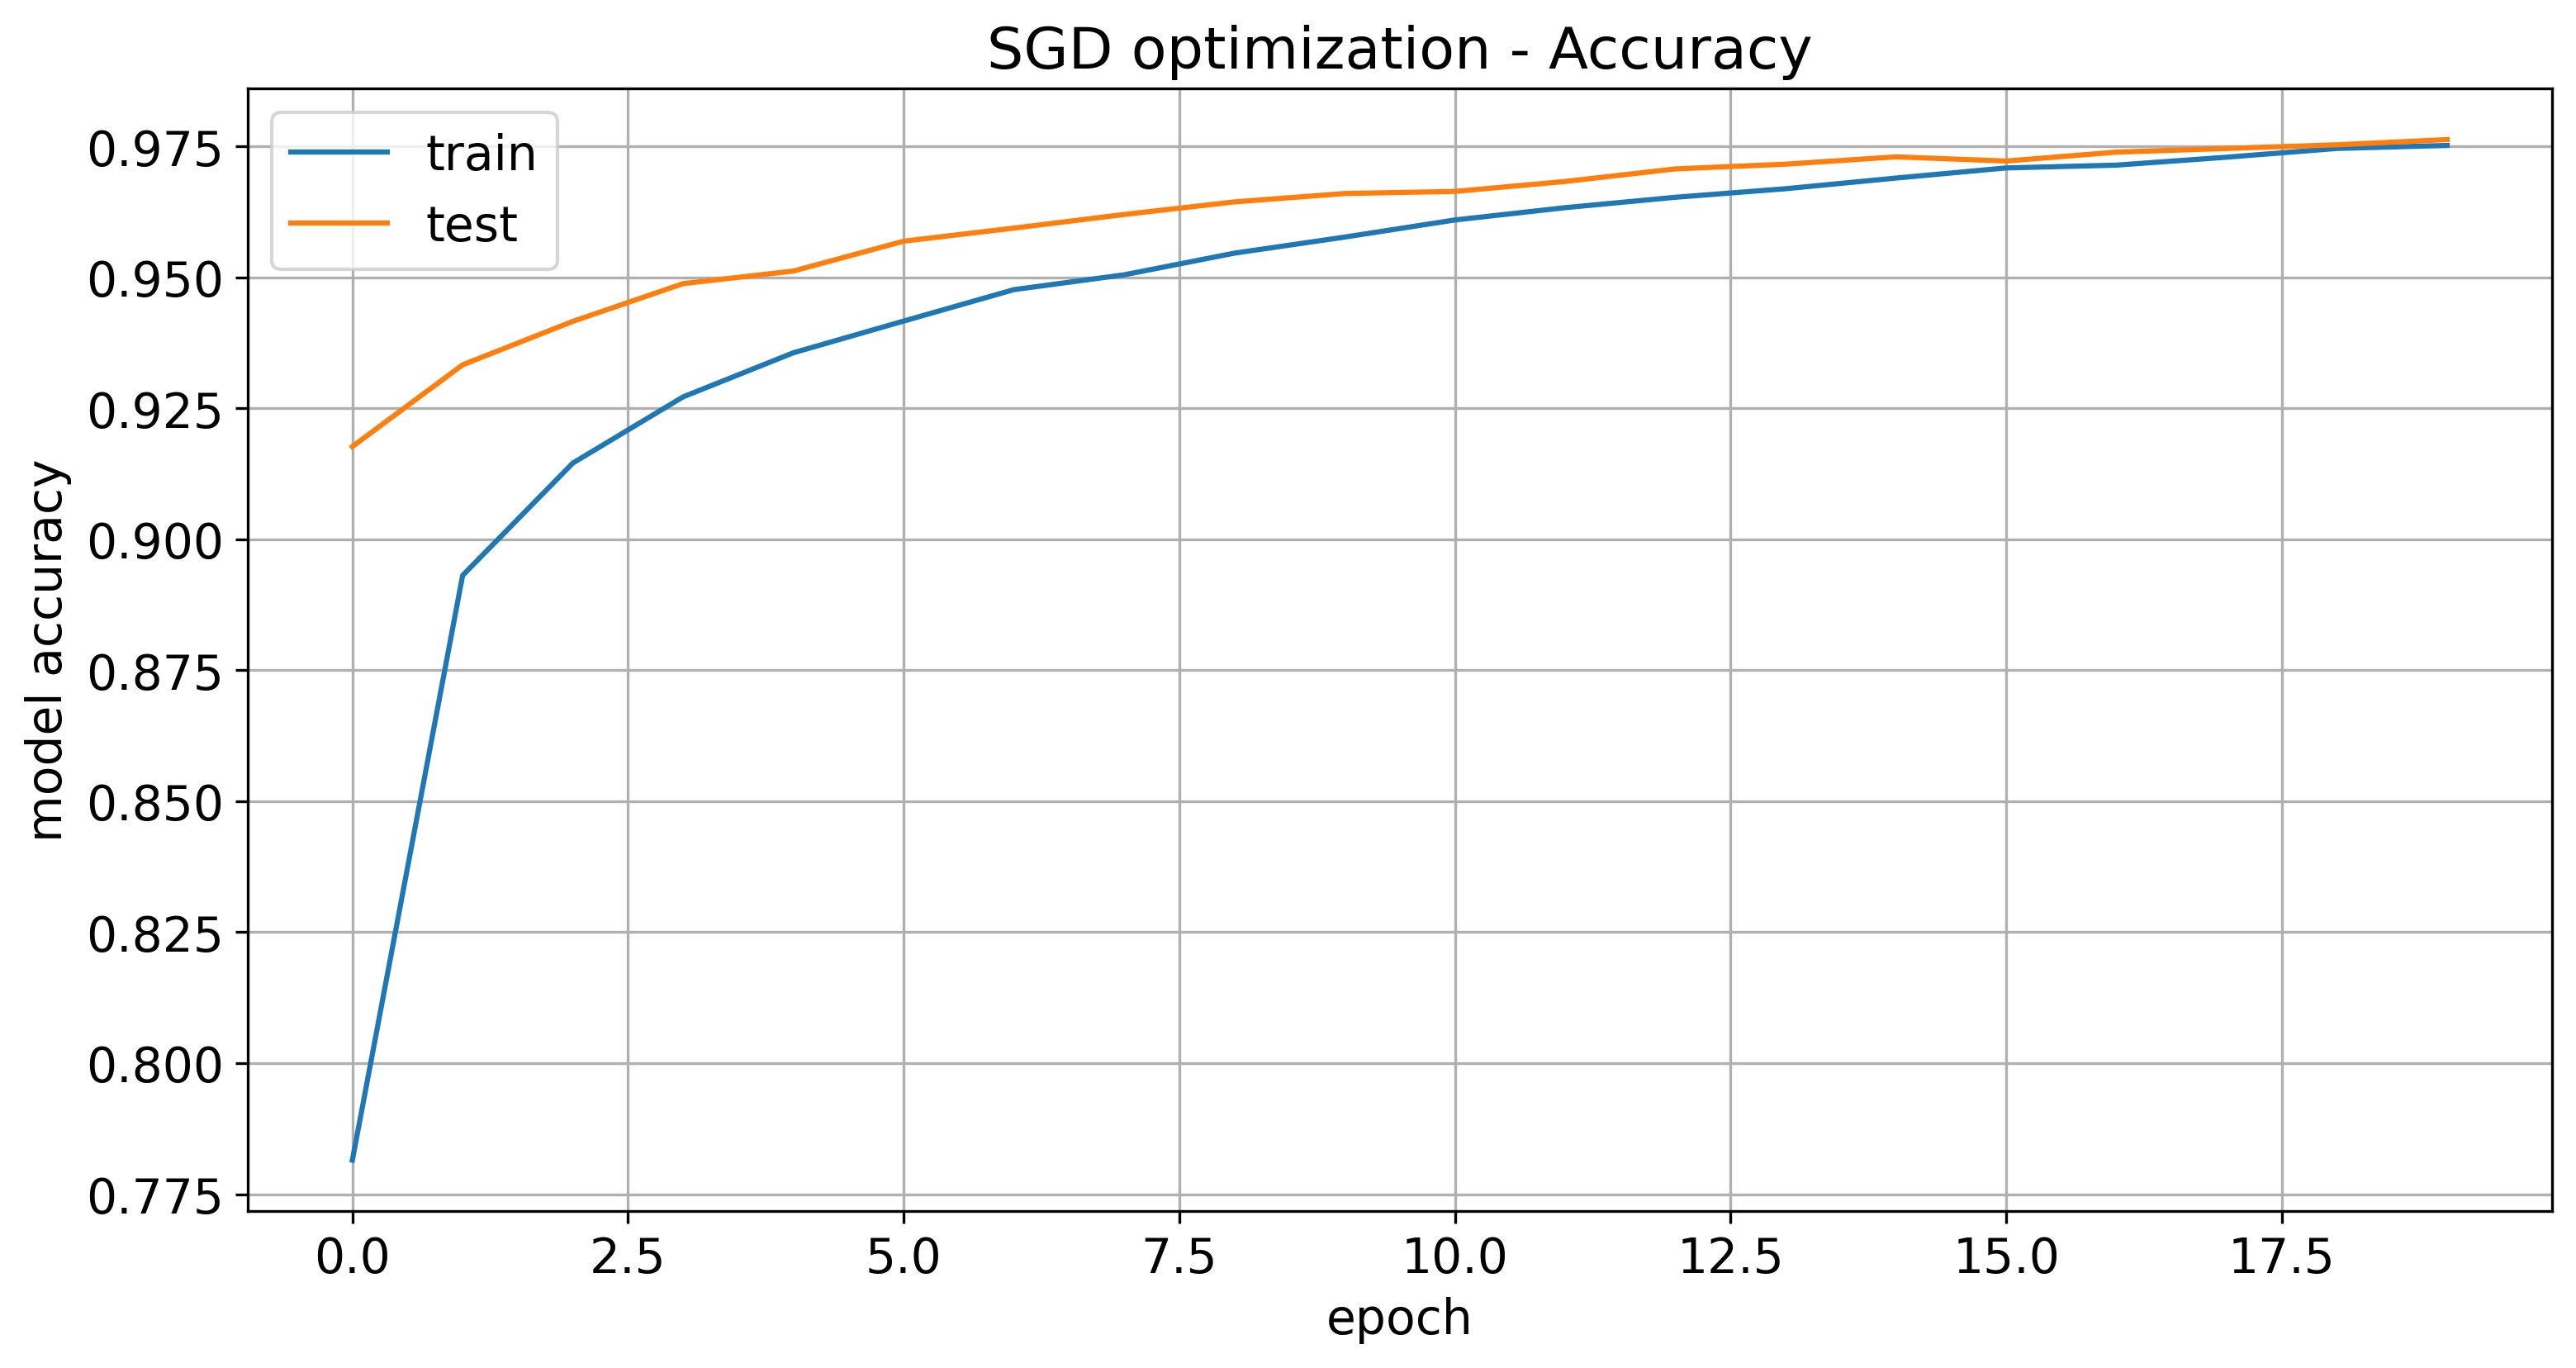

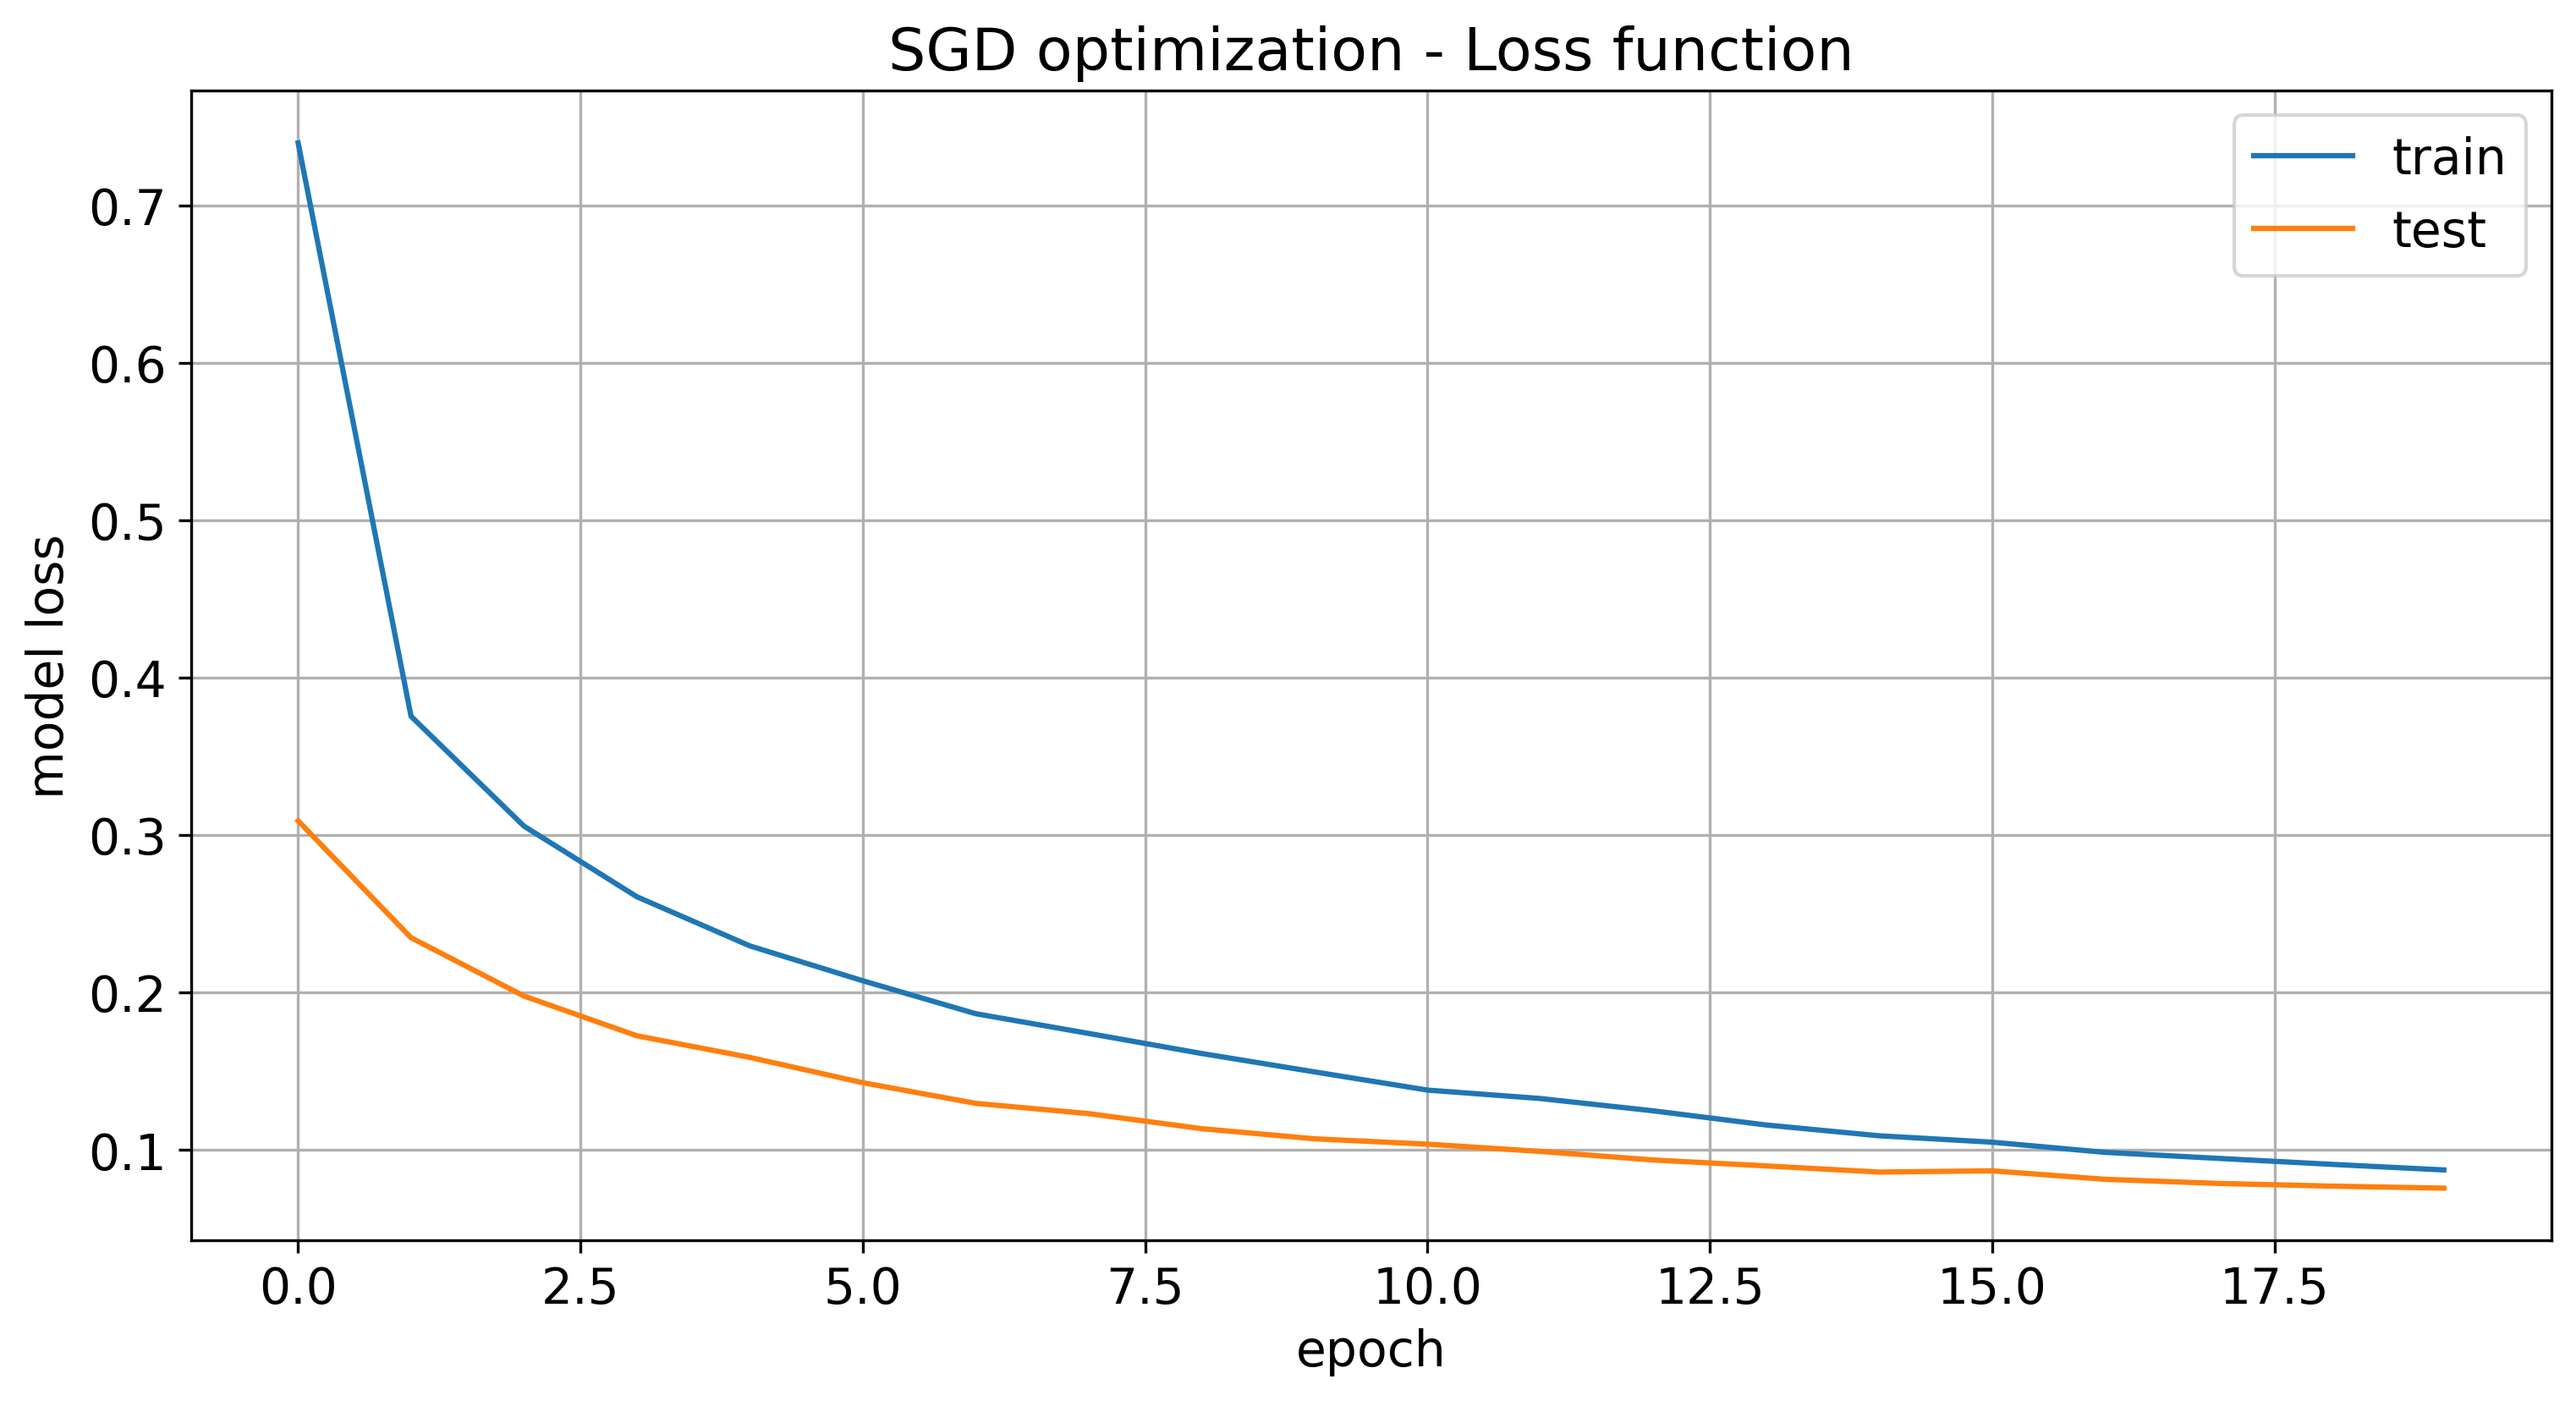

In [26]:
score = model_DNN.evaluate(X_test, Y_test, verbose=1)

print()
print('Test loss:', score[0])
print('Test accuracy:', score[1])

plt.rcParams.update({'font.size': 14})

plt.subplots(1,1, figsize=(12,6), dpi=300)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.ylabel('model accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.title("SGD optimization - Accuracy")
plt.grid(True)
plt.savefig("./imgs/DNN/sgd_acc.png")
plt.show()

plt.subplots(1,1, figsize=(12,6), dpi=300)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('model loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.title("SGD optimization - Loss function")
plt.grid(True)
plt.savefig("./imgs/DNN/sgd_loss.png")
plt.show()

In [27]:
#X_test = X_test.reshape(X_test.shape[0], img_rows*img_cols)
predictions = model_DNN.predict(X_test)

X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols,1)

313/313 [==============================] - 0s 1ms/step


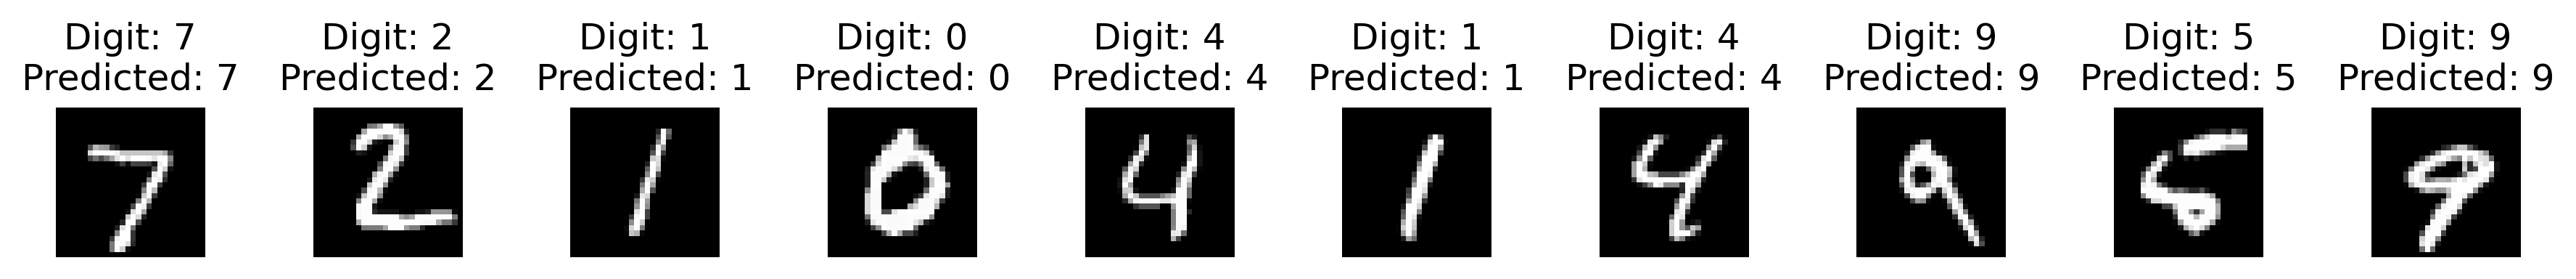

In [28]:
plt.rcParams.update({'font.size': 10})

plt.figure(figsize=(15, 2), dpi=300) 
for i in range(10):    
    ax = plt.subplot(2, 10, i + 1)    
    plt.imshow(X_test[i, :, :, 0], cmap='gray')    
    plt.title("Digit: {}\nPredicted: {}".format(np.argmax(Y_test[i]), np.argmax(predictions[i])))    
    plt.axis('off')
plt.savefig("./imgs/DNN/sgd_samples.png")
plt.show()

In [29]:
# ADAM OPTIMIZATION
opt = "adam"
batch_size = 32
epochs = 20

model_DNN = compile_model(opt)

X_test = X_test.reshape(X_test.shape[0], img_rows*img_cols)

history = model_DNN.fit(X_train, Y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(X_test, Y_test))

Epoch 1/20
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2885 - acc: 0.9157 - val_loss: 0.1168 - val_acc: 0.9614
Epoch 2/20
1875/1875 [==============================] - 4s 2ms/step - loss: 0.1219 - acc: 0.9652 - val_loss: 0.0881 - val_acc: 0.9722
Epoch 3/20
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0863 - acc: 0.9745 - val_loss: 0.0874 - val_acc: 0.9749
Epoch 4/20
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0690 - acc: 0.9793 - val_loss: 0.0725 - val_acc: 0.9787
Epoch 5/20
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0556 - acc: 0.9834 - val_loss: 0.0747 - val_acc: 0.9783
Epoch 6/20
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0459 - acc: 0.9863 - val_loss: 0.0724 - val_acc: 0.9803
Epoch 7/20
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0398 - acc: 0.9880 - val_loss: 0.0843 - val_acc: 0.9784
Epoch 8/20
1875/1875 [==============================] - 4s 2ms

313/313 [==============================] - 0s 1ms/step - loss: 0.1240 - acc: 0.9814

Test loss: 0.12399817258119583
Test accuracy: 0.9814000129699707


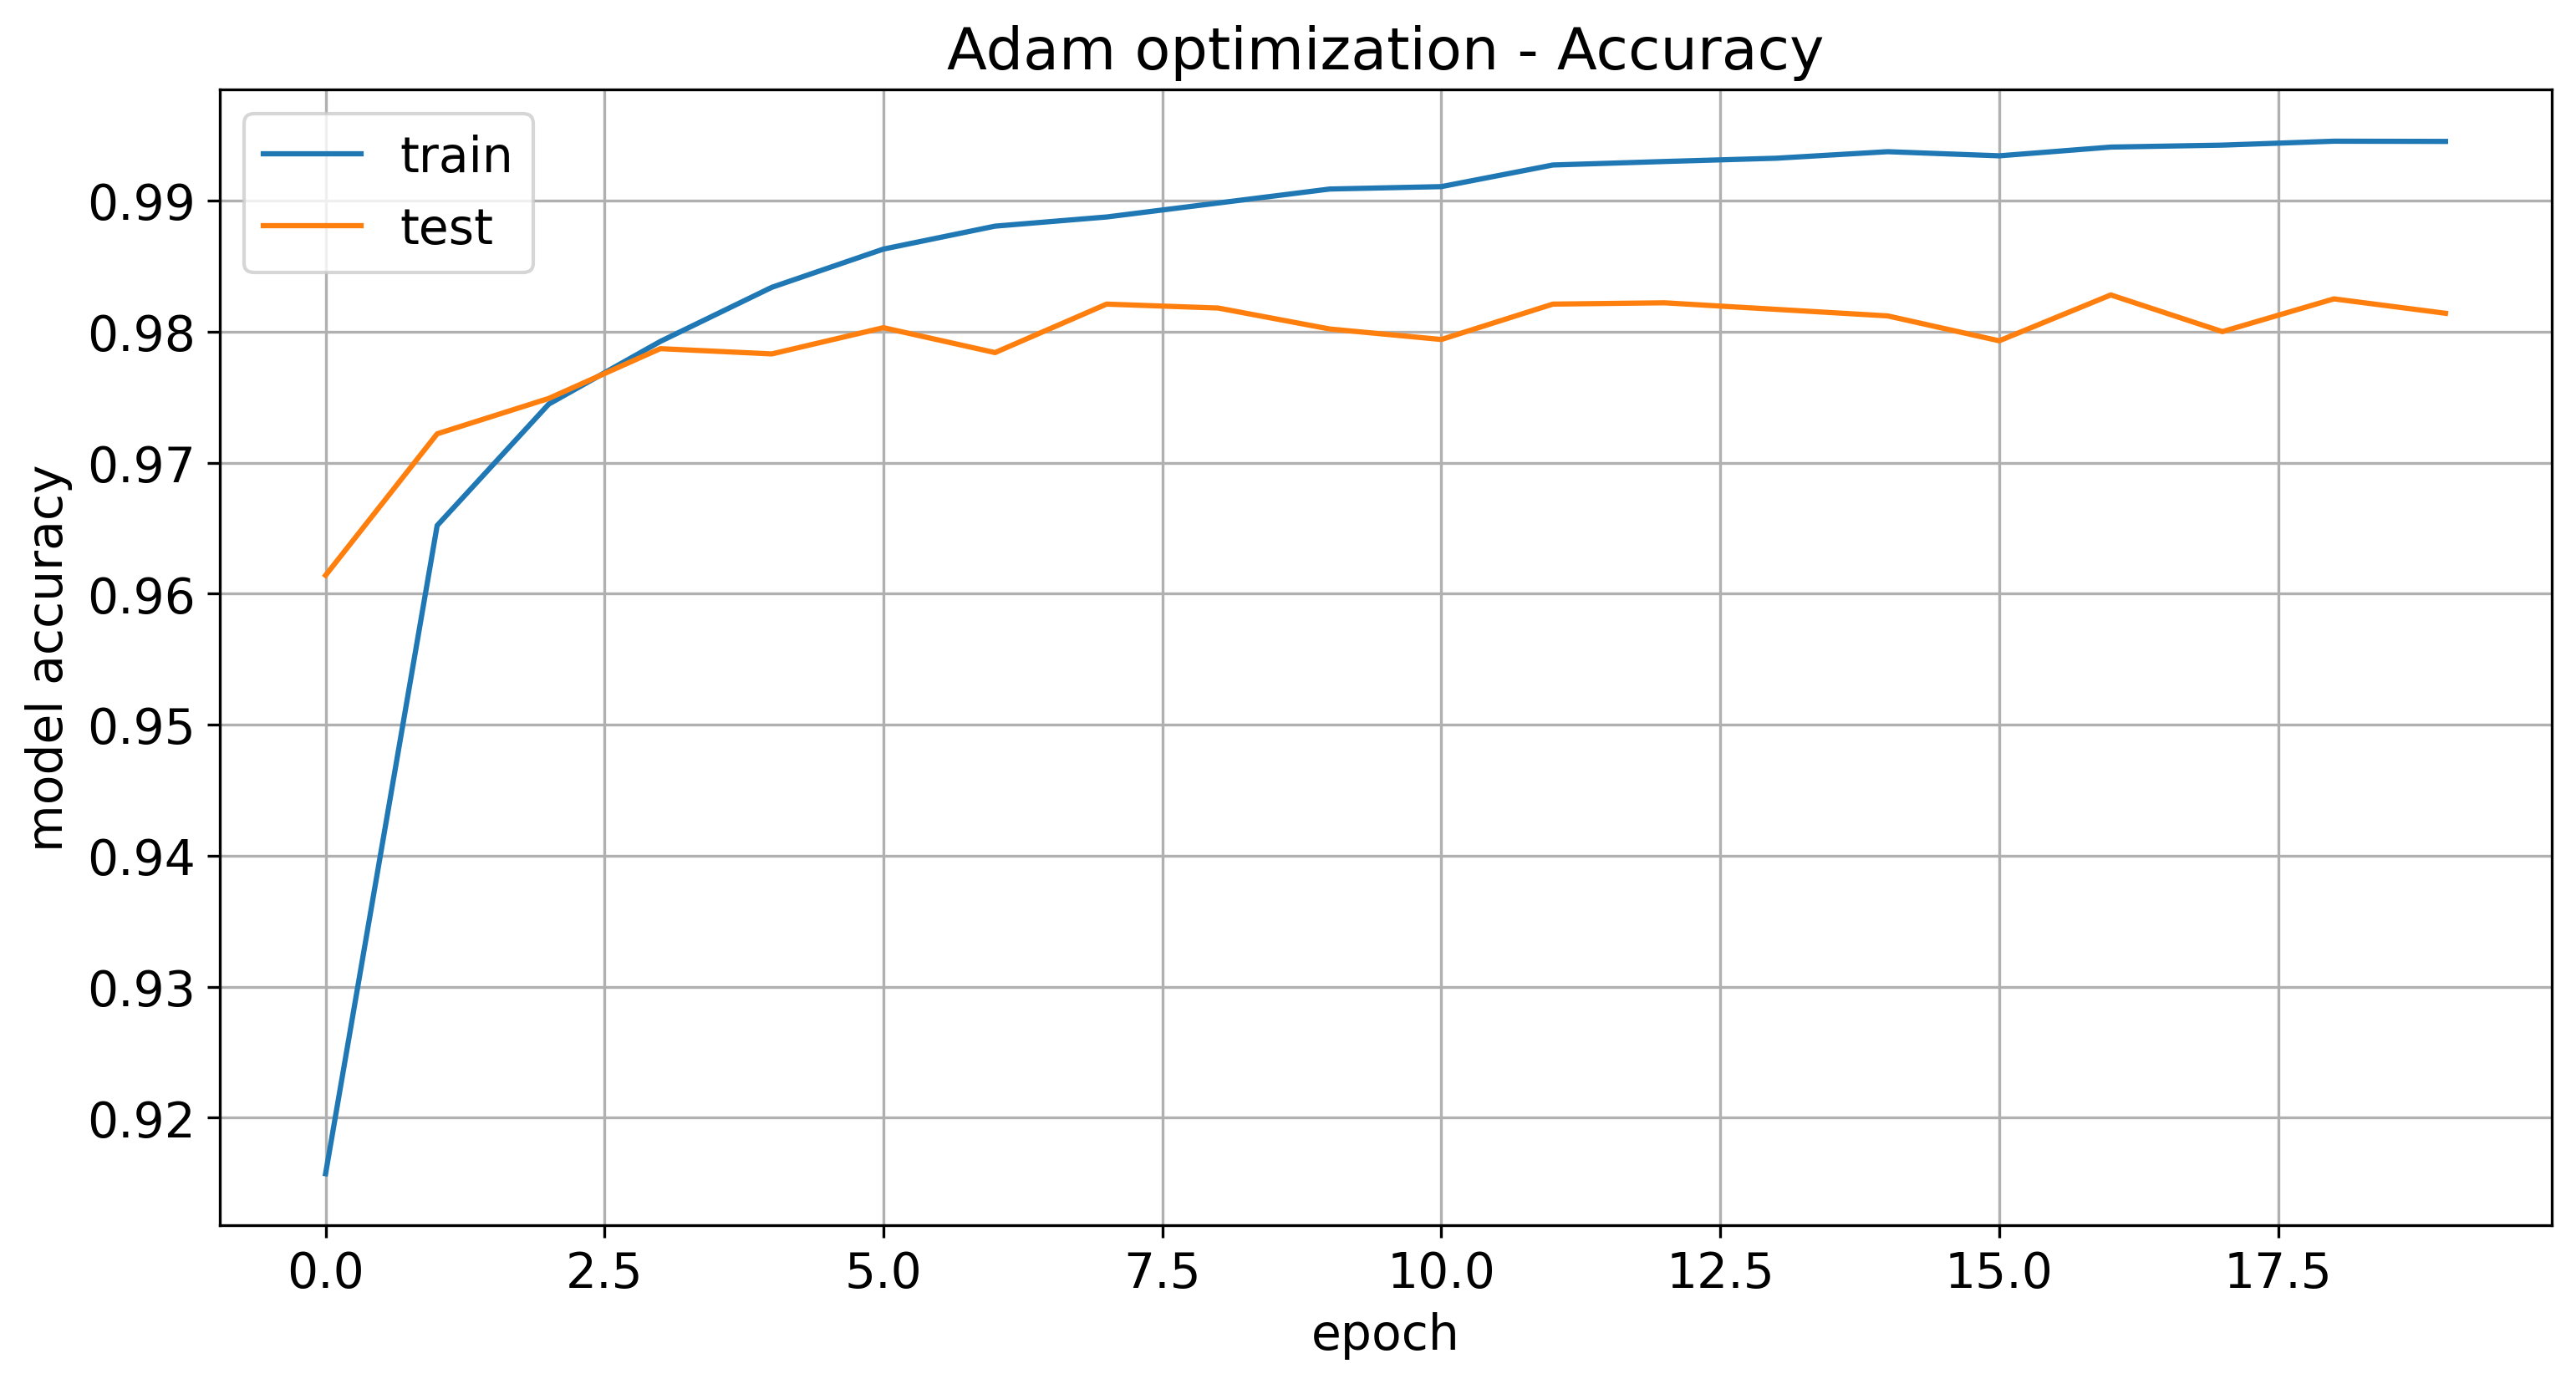

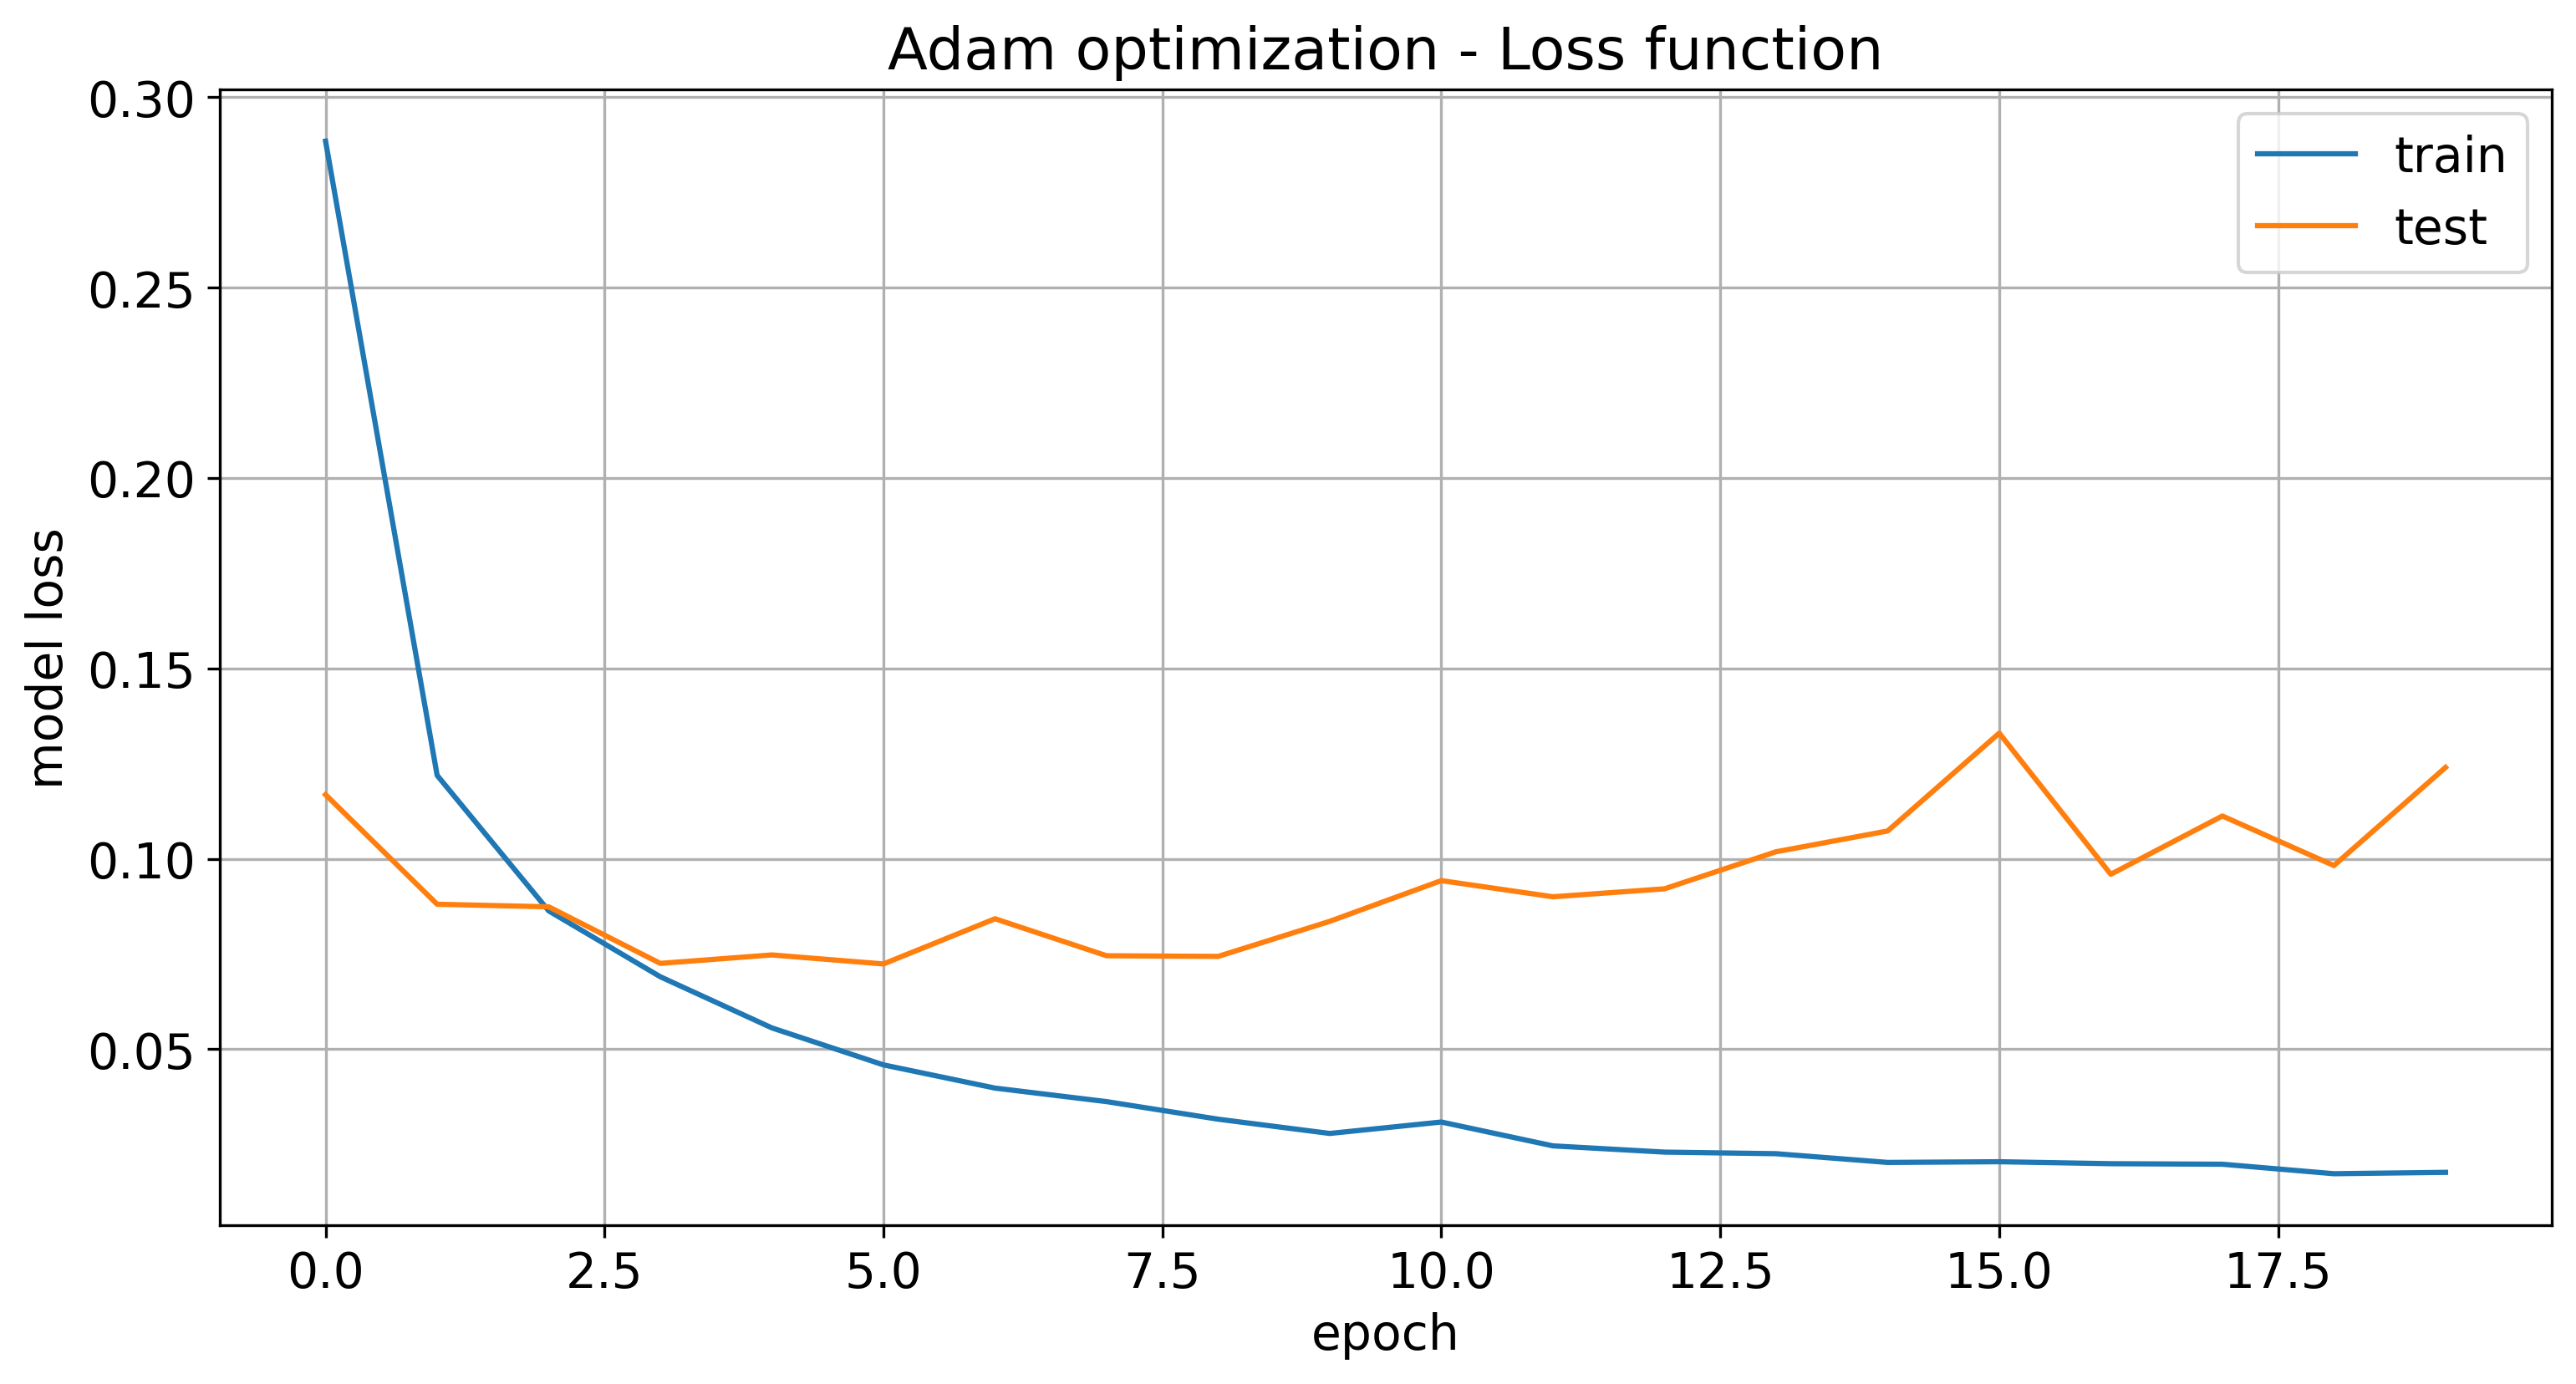

In [30]:
X_test = X_test.reshape(X_test.shape[0], img_rows*img_cols)
score = model_DNN.evaluate(X_test, Y_test, verbose=1)

print()
print('Test loss:', score[0])
print('Test accuracy:', score[1])

plt.rcParams.update({'font.size': 14})

plt.subplots(1,1, figsize=(12,6), dpi=300)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.ylabel('model accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.title("Adam optimization - Accuracy")
plt.grid(True)
plt.savefig("./imgs/DNN/adam_acc.png")
plt.show()

plt.subplots(1,1, figsize=(12,6), dpi=300)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('model loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.title("Adam optimization - Loss function")
plt.grid(True)
plt.savefig("./imgs/DNN/adam_loss.png")
plt.show()

In [31]:
#X_test = X_test.reshape(X_test.shape[0], img_rows*img_cols)
predictions = model_DNN.predict(X_test)

X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols,1)

313/313 [==============================] - 0s 1ms/step


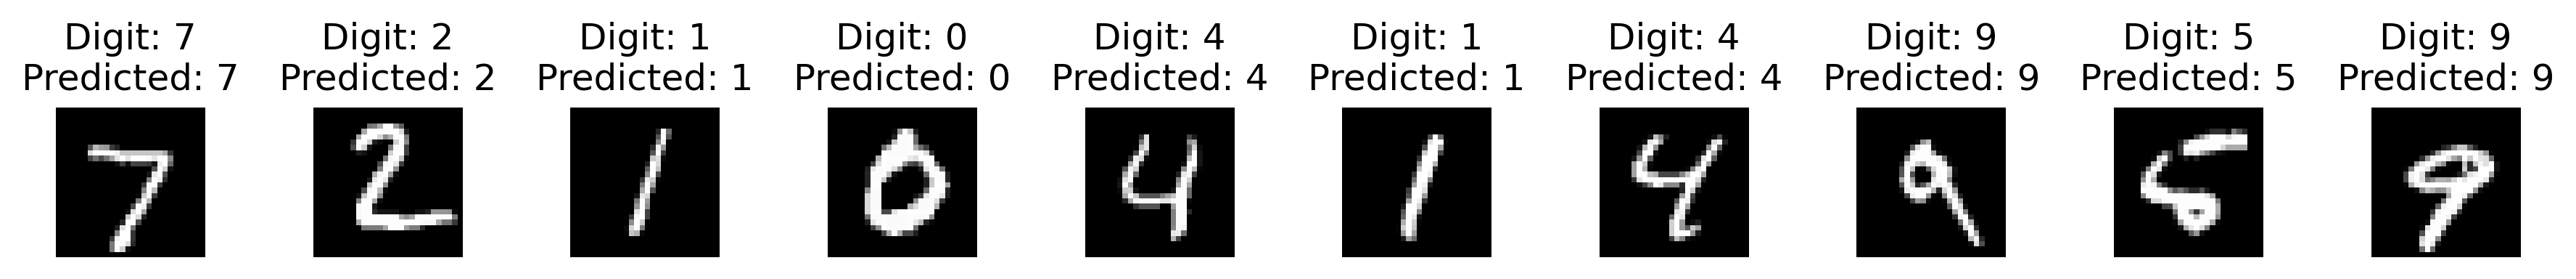

In [32]:
plt.rcParams.update({'font.size': 10})

plt.figure(figsize=(15, 2), dpi=300) 
for i in range(10):    
    ax = plt.subplot(2, 10, i + 1)    
    plt.imshow(X_test[i, :, :, 0], cmap='gray')    
    plt.title("Digit: {}\nPredicted: {}".format(np.argmax(Y_test[i]), np.argmax(predictions[i])))    
    plt.axis('off')
plt.savefig("./imgs/DNN/adam_samples.png")
plt.show()

In [33]:
# ADADELTA OPTIMIZATION
opt = "adadelta"
batch_size = 32
epochs = 20

X_test = X_test.reshape(X_test.shape[0], img_rows*img_cols)

model_DNN = compile_model(opt)

history = model_DNN.fit(X_train, Y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(X_test, Y_test))

Epoch 1/20
1875/1875 [==============================] - 4s 2ms/step - loss: 2.2701 - acc: 0.1697 - val_loss: 2.1172 - val_acc: 0.3351
Epoch 2/20
1875/1875 [==============================] - 4s 2ms/step - loss: 2.0772 - acc: 0.2923 - val_loss: 1.9363 - val_acc: 0.5193
Epoch 3/20
1875/1875 [==============================] - 4s 2ms/step - loss: 1.9127 - acc: 0.4071 - val_loss: 1.7638 - val_acc: 0.6168
Epoch 4/20
1875/1875 [==============================] - 4s 2ms/step - loss: 1.7588 - acc: 0.4882 - val_loss: 1.6001 - val_acc: 0.6720
Epoch 5/20
1875/1875 [==============================] - 4s 2ms/step - loss: 1.6182 - acc: 0.5501 - val_loss: 1.4500 - val_acc: 0.7071
Epoch 6/20
1875/1875 [==============================] - 4s 2ms/step - loss: 1.4954 - acc: 0.5883 - val_loss: 1.3173 - val_acc: 0.7342
Epoch 7/20
1875/1875 [==============================] - 4s 2ms/step - loss: 1.3848 - acc: 0.6225 - val_loss: 1.2010 - val_acc: 0.7578
Epoch 8/20
1875/1875 [==============================] - 4s 2ms

313/313 [==============================] - 0s 1ms/step - loss: 0.5759 - acc: 0.8728

Test loss: 0.5758523344993591
Test accuracy: 0.8727999925613403


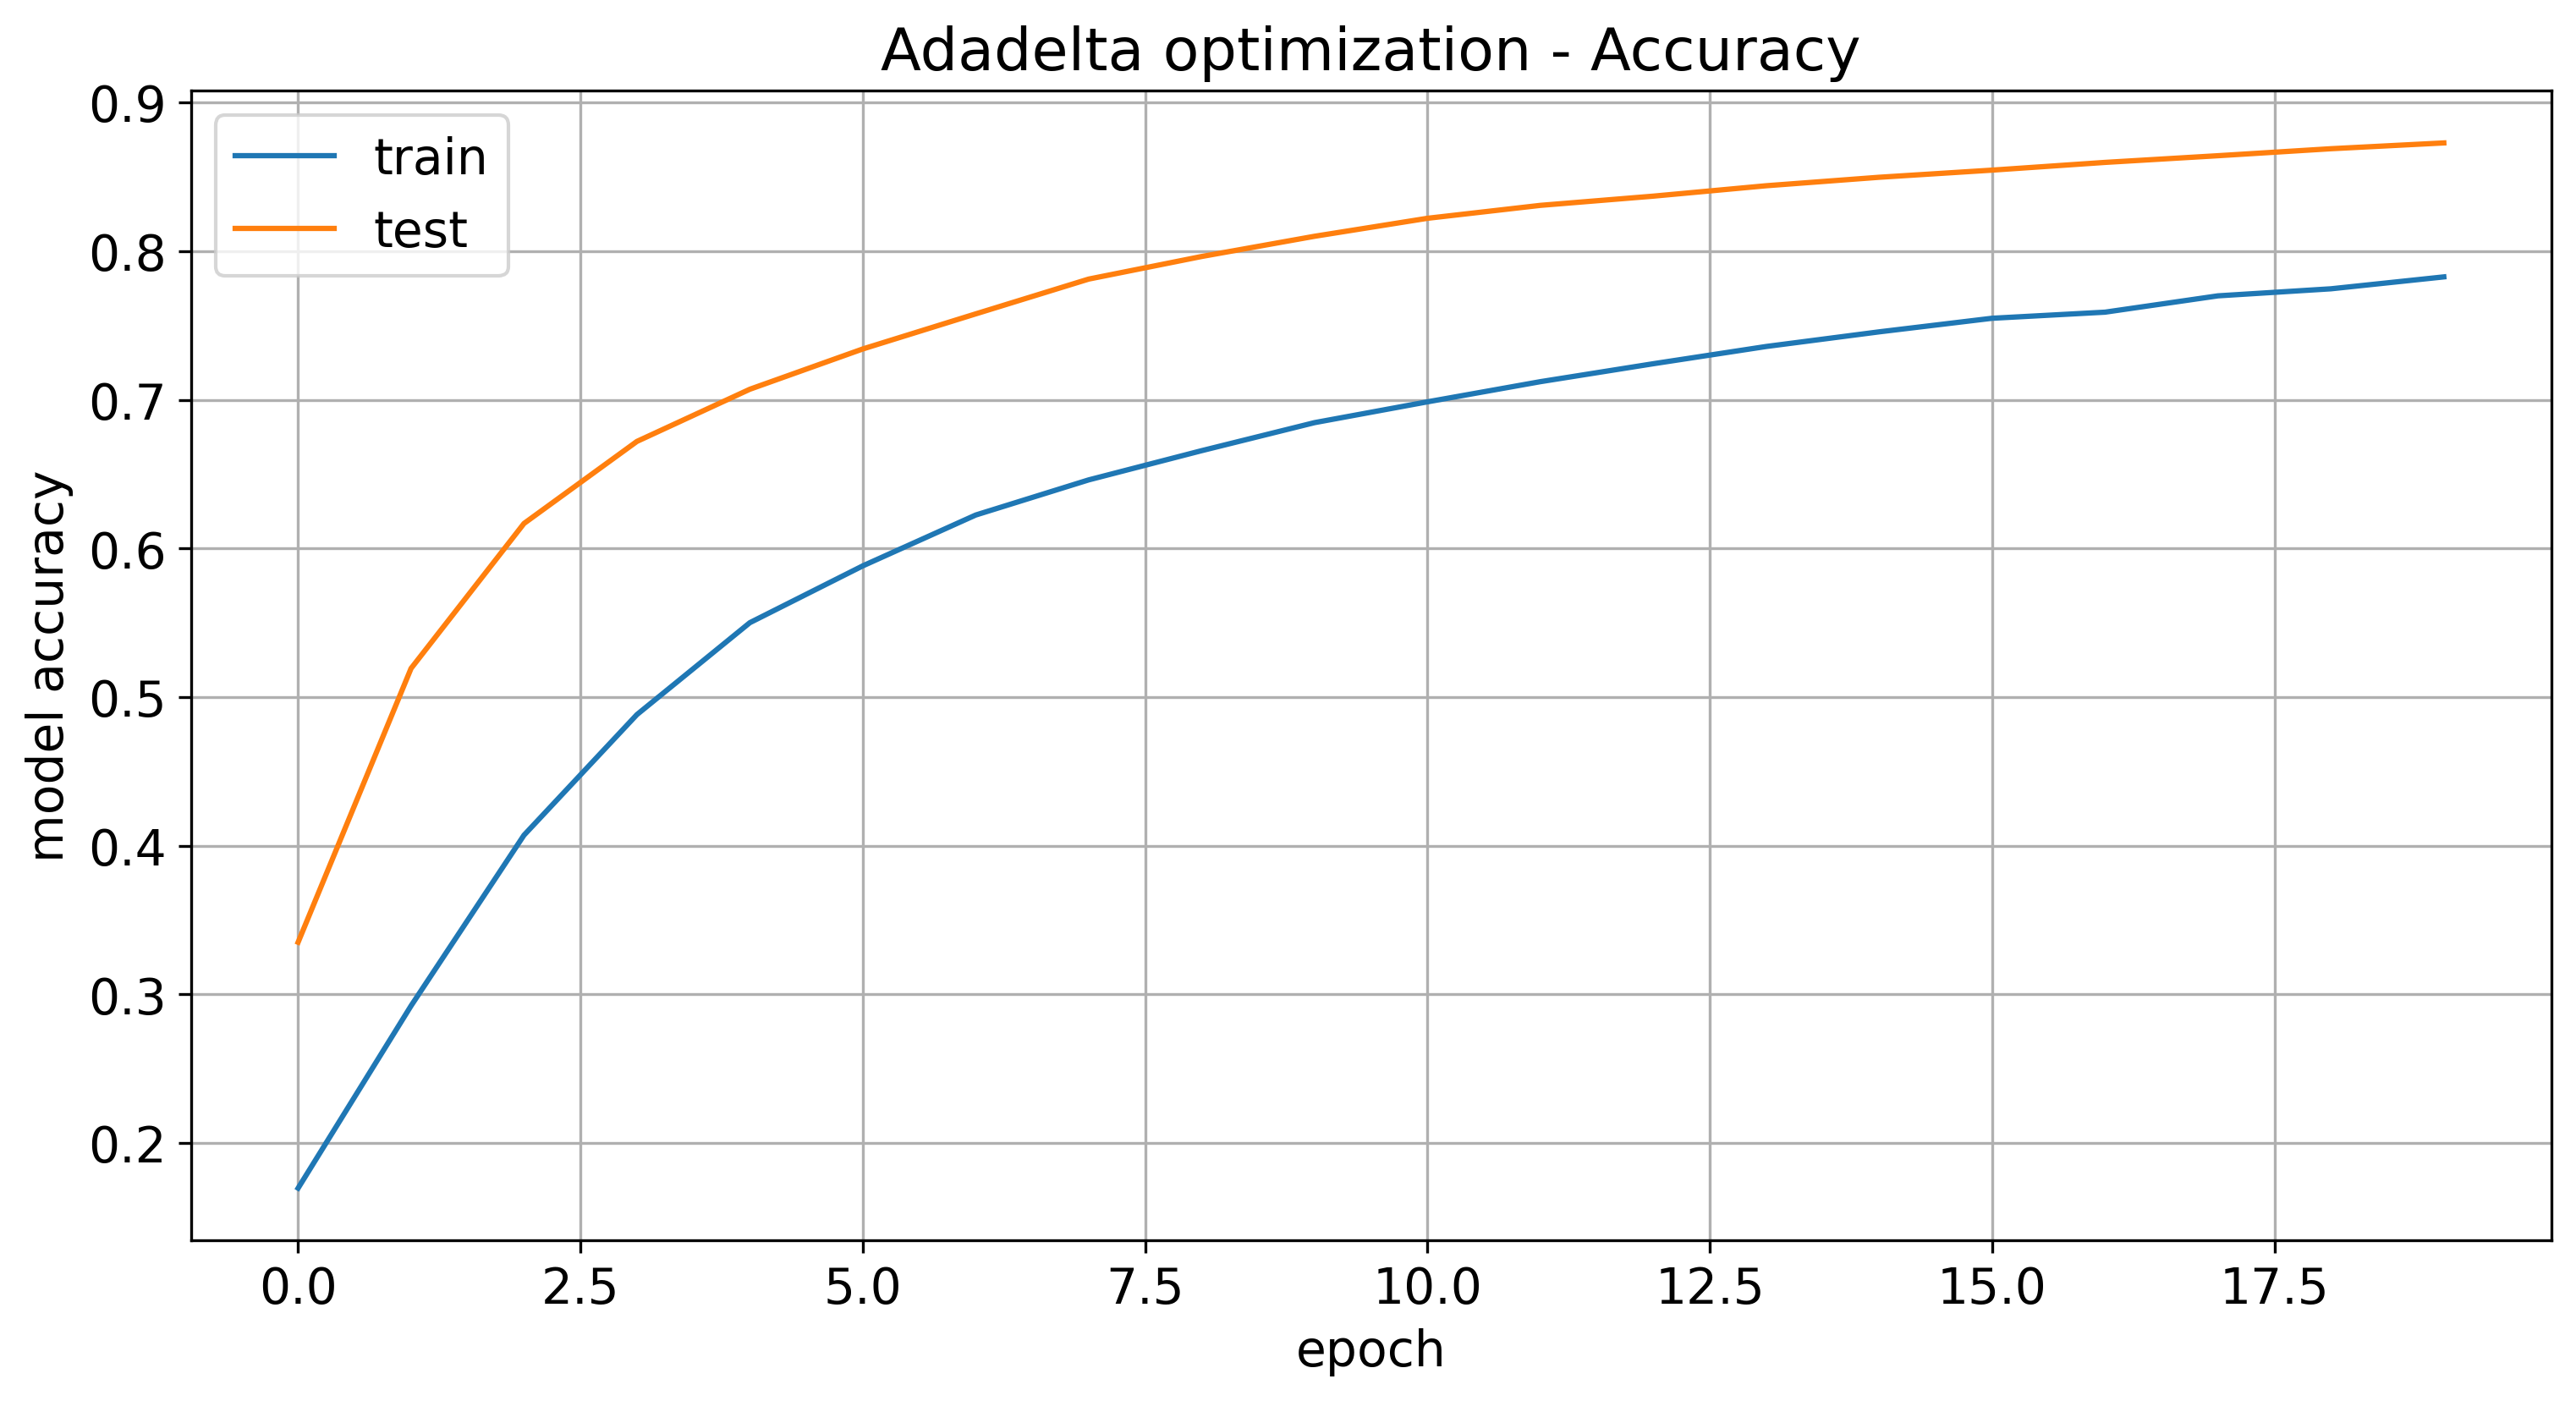

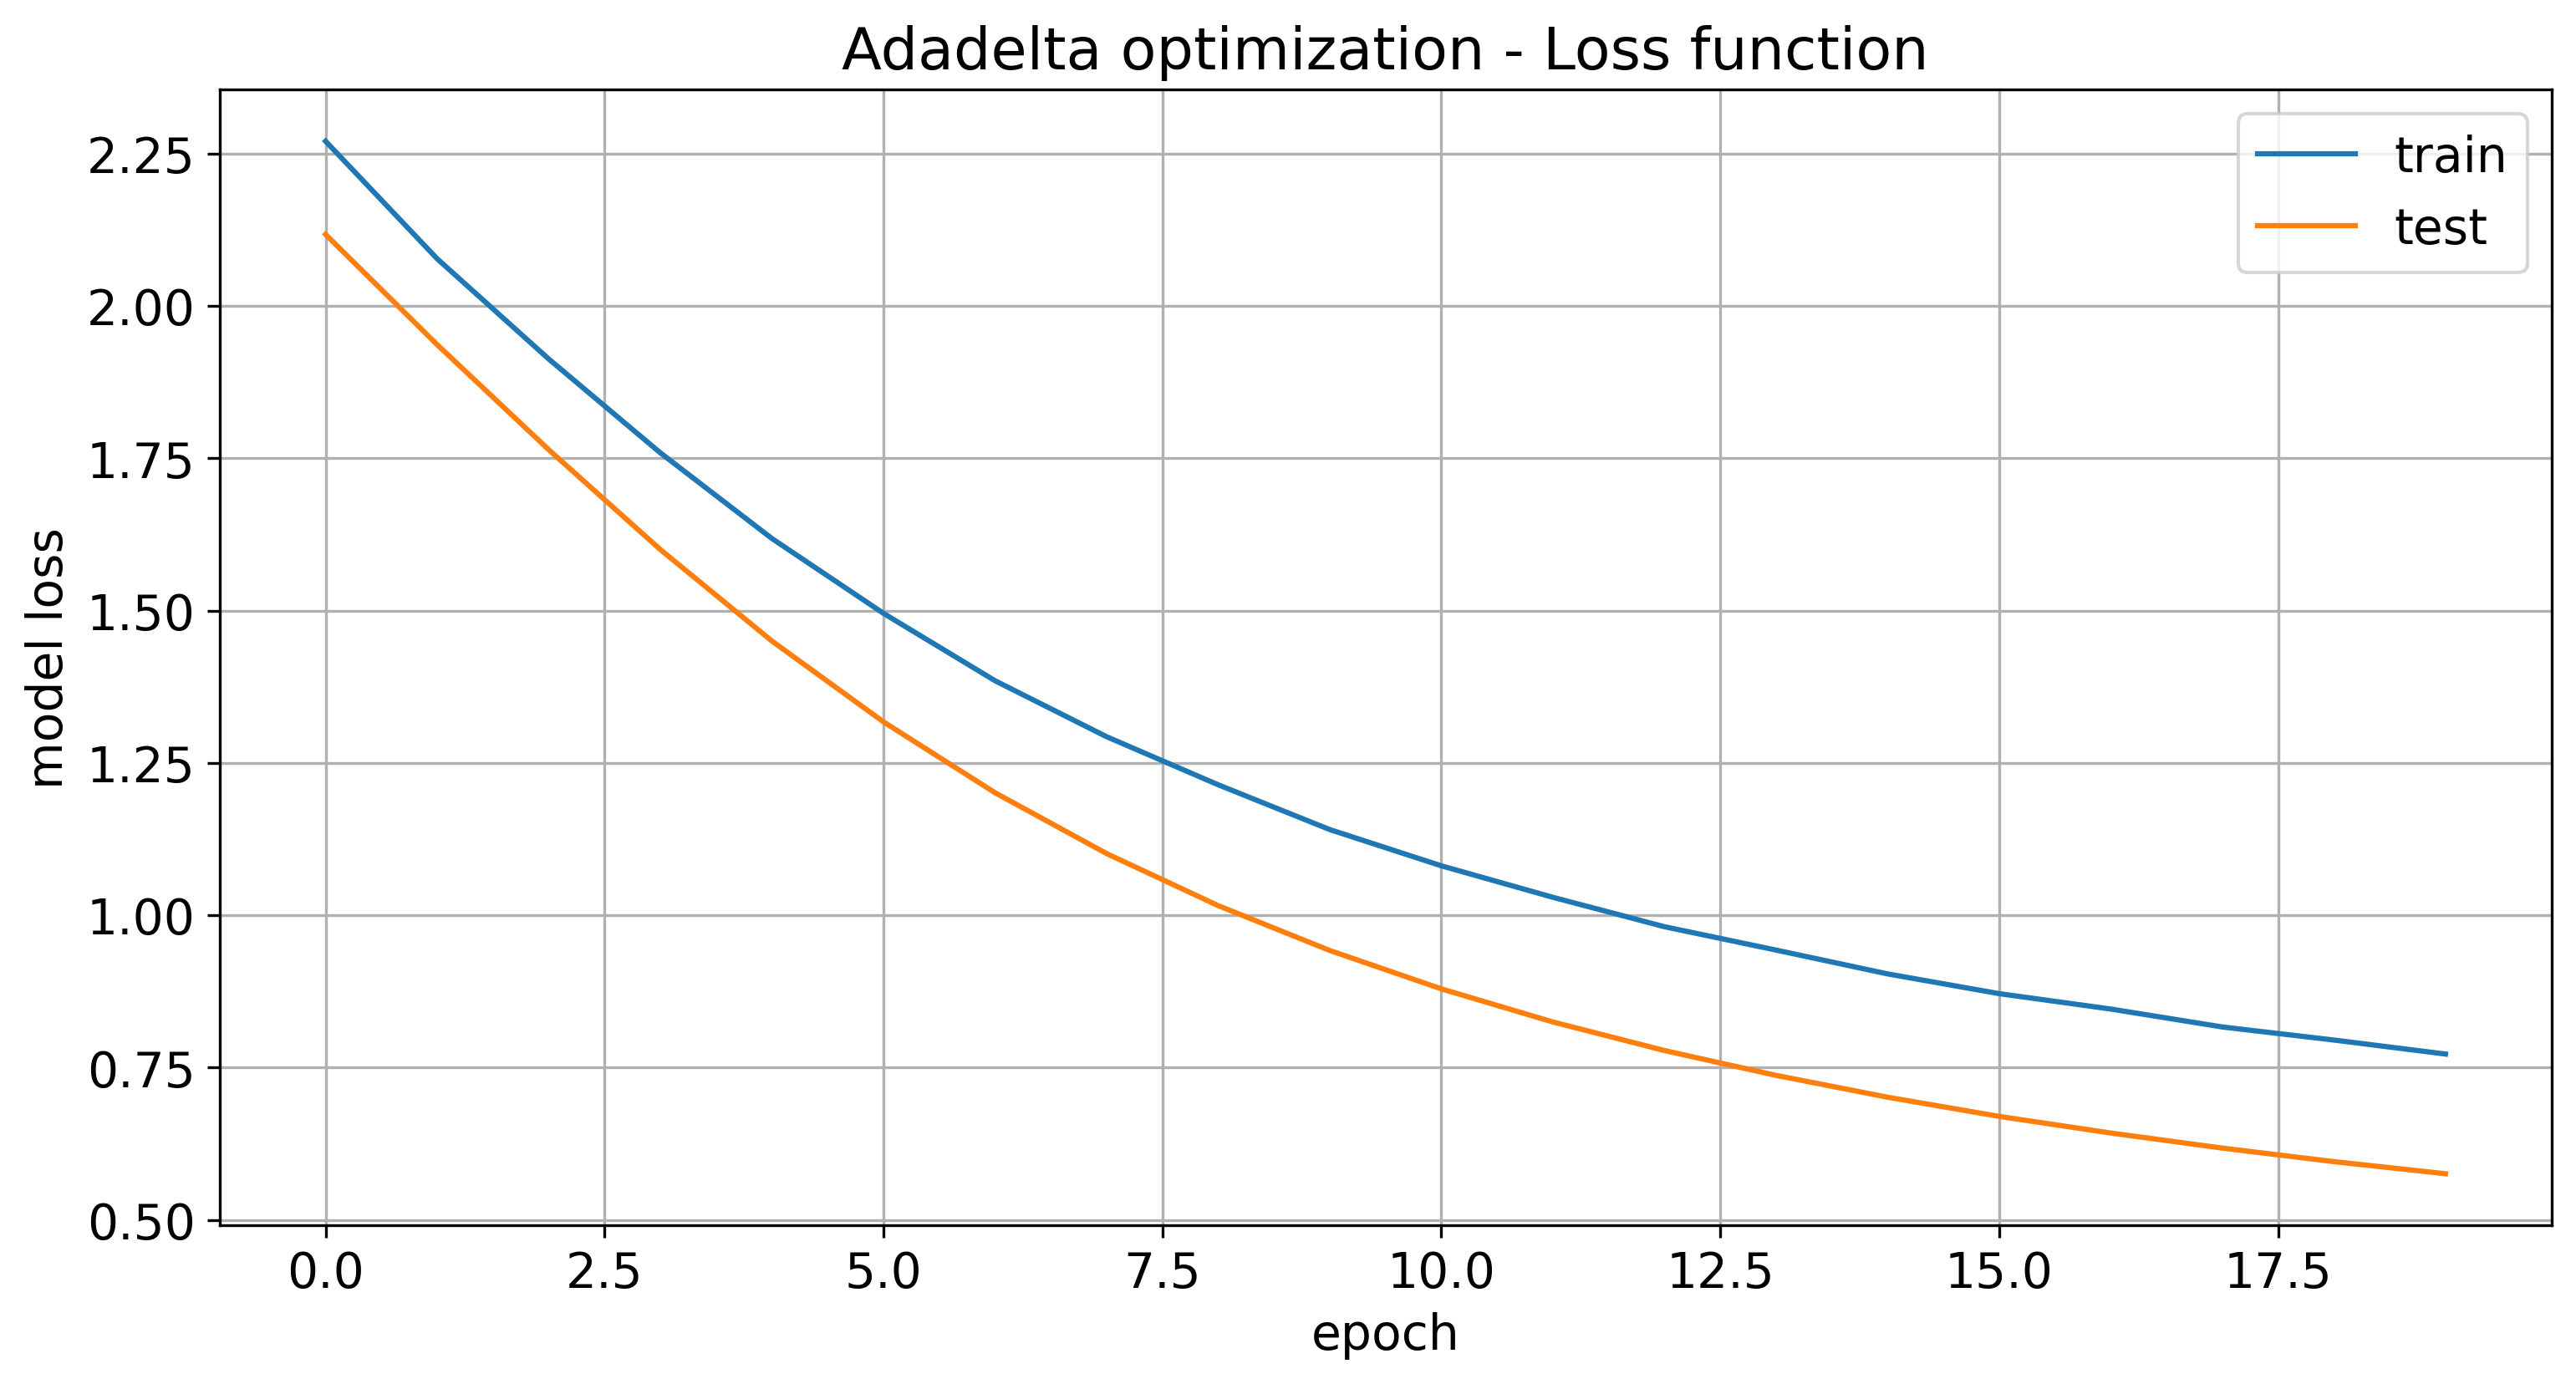

In [34]:
score = model_DNN.evaluate(X_test, Y_test, verbose=1)

print()
print('Test loss:', score[0])
print('Test accuracy:', score[1])

plt.rcParams.update({'font.size': 14})

plt.subplots(1,1, figsize=(12,6), dpi=300)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.ylabel('model accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.title("Adadelta optimization - Accuracy")
plt.grid(True)
plt.savefig("./imgs/DNN/adadelta_acc.png")
plt.show()

plt.subplots(1,1, figsize=(12,6), dpi=300)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('model loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.title("Adadelta optimization - Loss function")
plt.grid(True)
plt.savefig("./imgs/DNN/adadelta_loss.png")
plt.show()

In [35]:
#X_test = X_test.reshape(X_test.shape[0], img_rows*img_cols)
predictions = model_DNN.predict(X_test)

X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols,1)

313/313 [==============================] - 0s 1ms/step


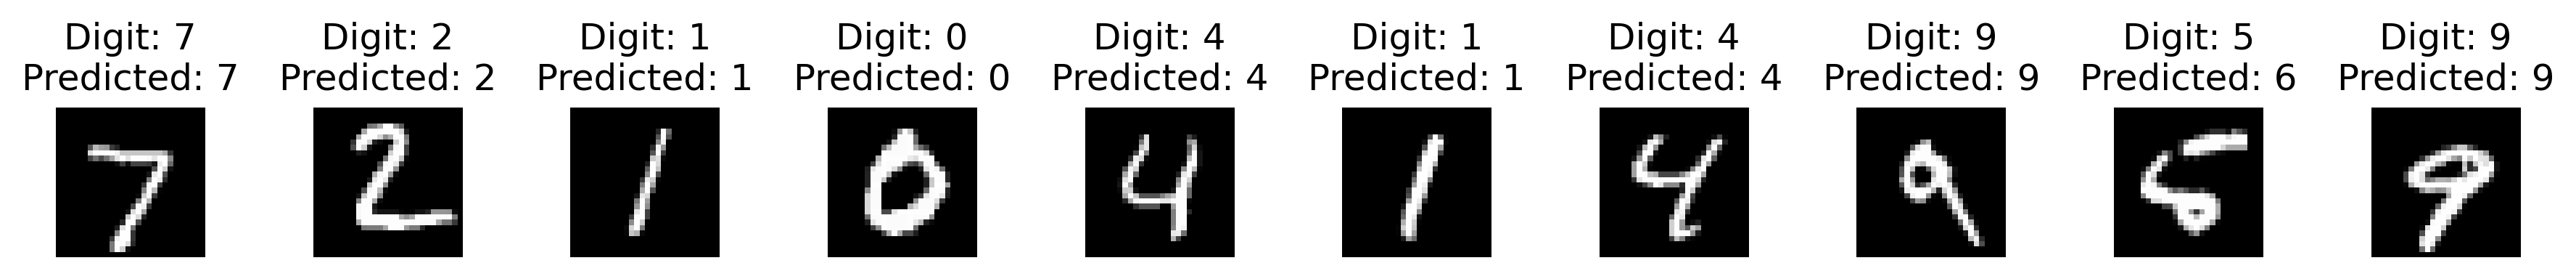

In [36]:
plt.rcParams.update({'font.size': 10})

plt.figure(figsize=(15, 2), dpi=300) 
for i in range(10):    
    ax = plt.subplot(2, 10, i + 1)    
    plt.imshow(X_test[i, :, :, 0], cmap='gray')    
    plt.title("Digit: {}\nPredicted: {}".format(np.argmax(Y_test[i]), np.argmax(predictions[i])))    
    plt.axis('off')
plt.savefig("./imgs/DNN/adadelta_samples.png")
plt.show()

### <span style="color:darkblue"> Exercise 12.2 </span>

I built the CNN with the objective in mind of getting to a test accuracy greater than 99% within 20 epochs, and trying to be as minimal as I could be. After a few trials I came up with the following CNN architecture:

    1. A convolutional layer with 10 5x5 filters.
    2. A pooling layer of size 2x2.
    3. A convolutional layer with 16 3x3 filters.
    4. Another 2x2 pooling layer.
    5. A flat dense layer with 100 nodes and dropout rate of 0.15.
    6. Another dense layer with 50 nodes and dropout rate of 0.15.
    7. A softmax output layer with 10 channels.
    
The hidden layers used a ReLU activation function. I optimized the network with SGD. In the end I obtained an accuracy rate of 98.99% (this may seem a little bit on the edge, but in other exploratory runs, which started with the PRNG in other states, I obtained consistently results above 99%. Indeed, before I run the notebook from the start to prepare it for submission, the accuracy was at 99.16%, and above 99% for the last four training epochs).

<img src="./imgs/CNN/CNN_acc.png?version=4">
<img src="./imgs/CNN/CNN_loss.png?version=4">
<img src="./imgs/CNN/CNN_samples.png?version=2">

In [37]:
def create_CNN():
    model = Sequential()
    model.add(Conv2D(10, kernel_size=(5, 5),
                     activation='relu',
                     input_shape=input_shape))

    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Conv2D(16, kernel_size=(3, 3),
                     activation='relu',
                     input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Flatten())
    model.add(Dropout(0.15))
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.15))
    model.add(Dense(50, activation='relu'))

    model.add(Dense(num_classes, activation='softmax'))  # Output layer
    
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer='SGD',
                  metrics=['acc'])
    return model

In [38]:
# training parameters
batch_size = 32
epochs = 20 

X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)
X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)

# create the deep conv net
model_CNN=create_CNN()

# train CNN
history = model_CNN.fit(X_train, Y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(X_test, Y_test))

# evaliate model
score = model_CNN.evaluate(X_test, Y_test, verbose=1)

# print performance
print()
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Epoch 1/20
1875/1875 [==============================] - 5s 3ms/step - loss: 0.7810 - acc: 0.7368 - val_loss: 0.1746 - val_acc: 0.9473
Epoch 2/20
1875/1875 [==============================] - 5s 2ms/step - loss: 0.2257 - acc: 0.9298 - val_loss: 0.1115 - val_acc: 0.9669
Epoch 3/20
1875/1875 [==============================] - 5s 3ms/step - loss: 0.1641 - acc: 0.9498 - val_loss: 0.0817 - val_acc: 0.9734
Epoch 4/20
1875/1875 [==============================] - 5s 3ms/step - loss: 0.1376 - acc: 0.9571 - val_loss: 0.0690 - val_acc: 0.9787
Epoch 5/20
1875/1875 [==============================] - 5s 2ms/step - loss: 0.1215 - acc: 0.9617 - val_loss: 0.0629 - val_acc: 0.9806
Epoch 6/20
1875/1875 [==============================] - 5s 2ms/step - loss: 0.1081 - acc: 0.9668 - val_loss: 0.0567 - val_acc: 0.9820
Epoch 7/20
1875/1875 [==============================] - 5s 2ms/step - loss: 0.0959 - acc: 0.9702 - val_loss: 0.0480 - val_acc: 0.9849
Epoch 8/20
1875/1875 [==============================] - 5s 3ms


Test loss: 0.029808789491653442
Test accuracy: 0.9901000261306763


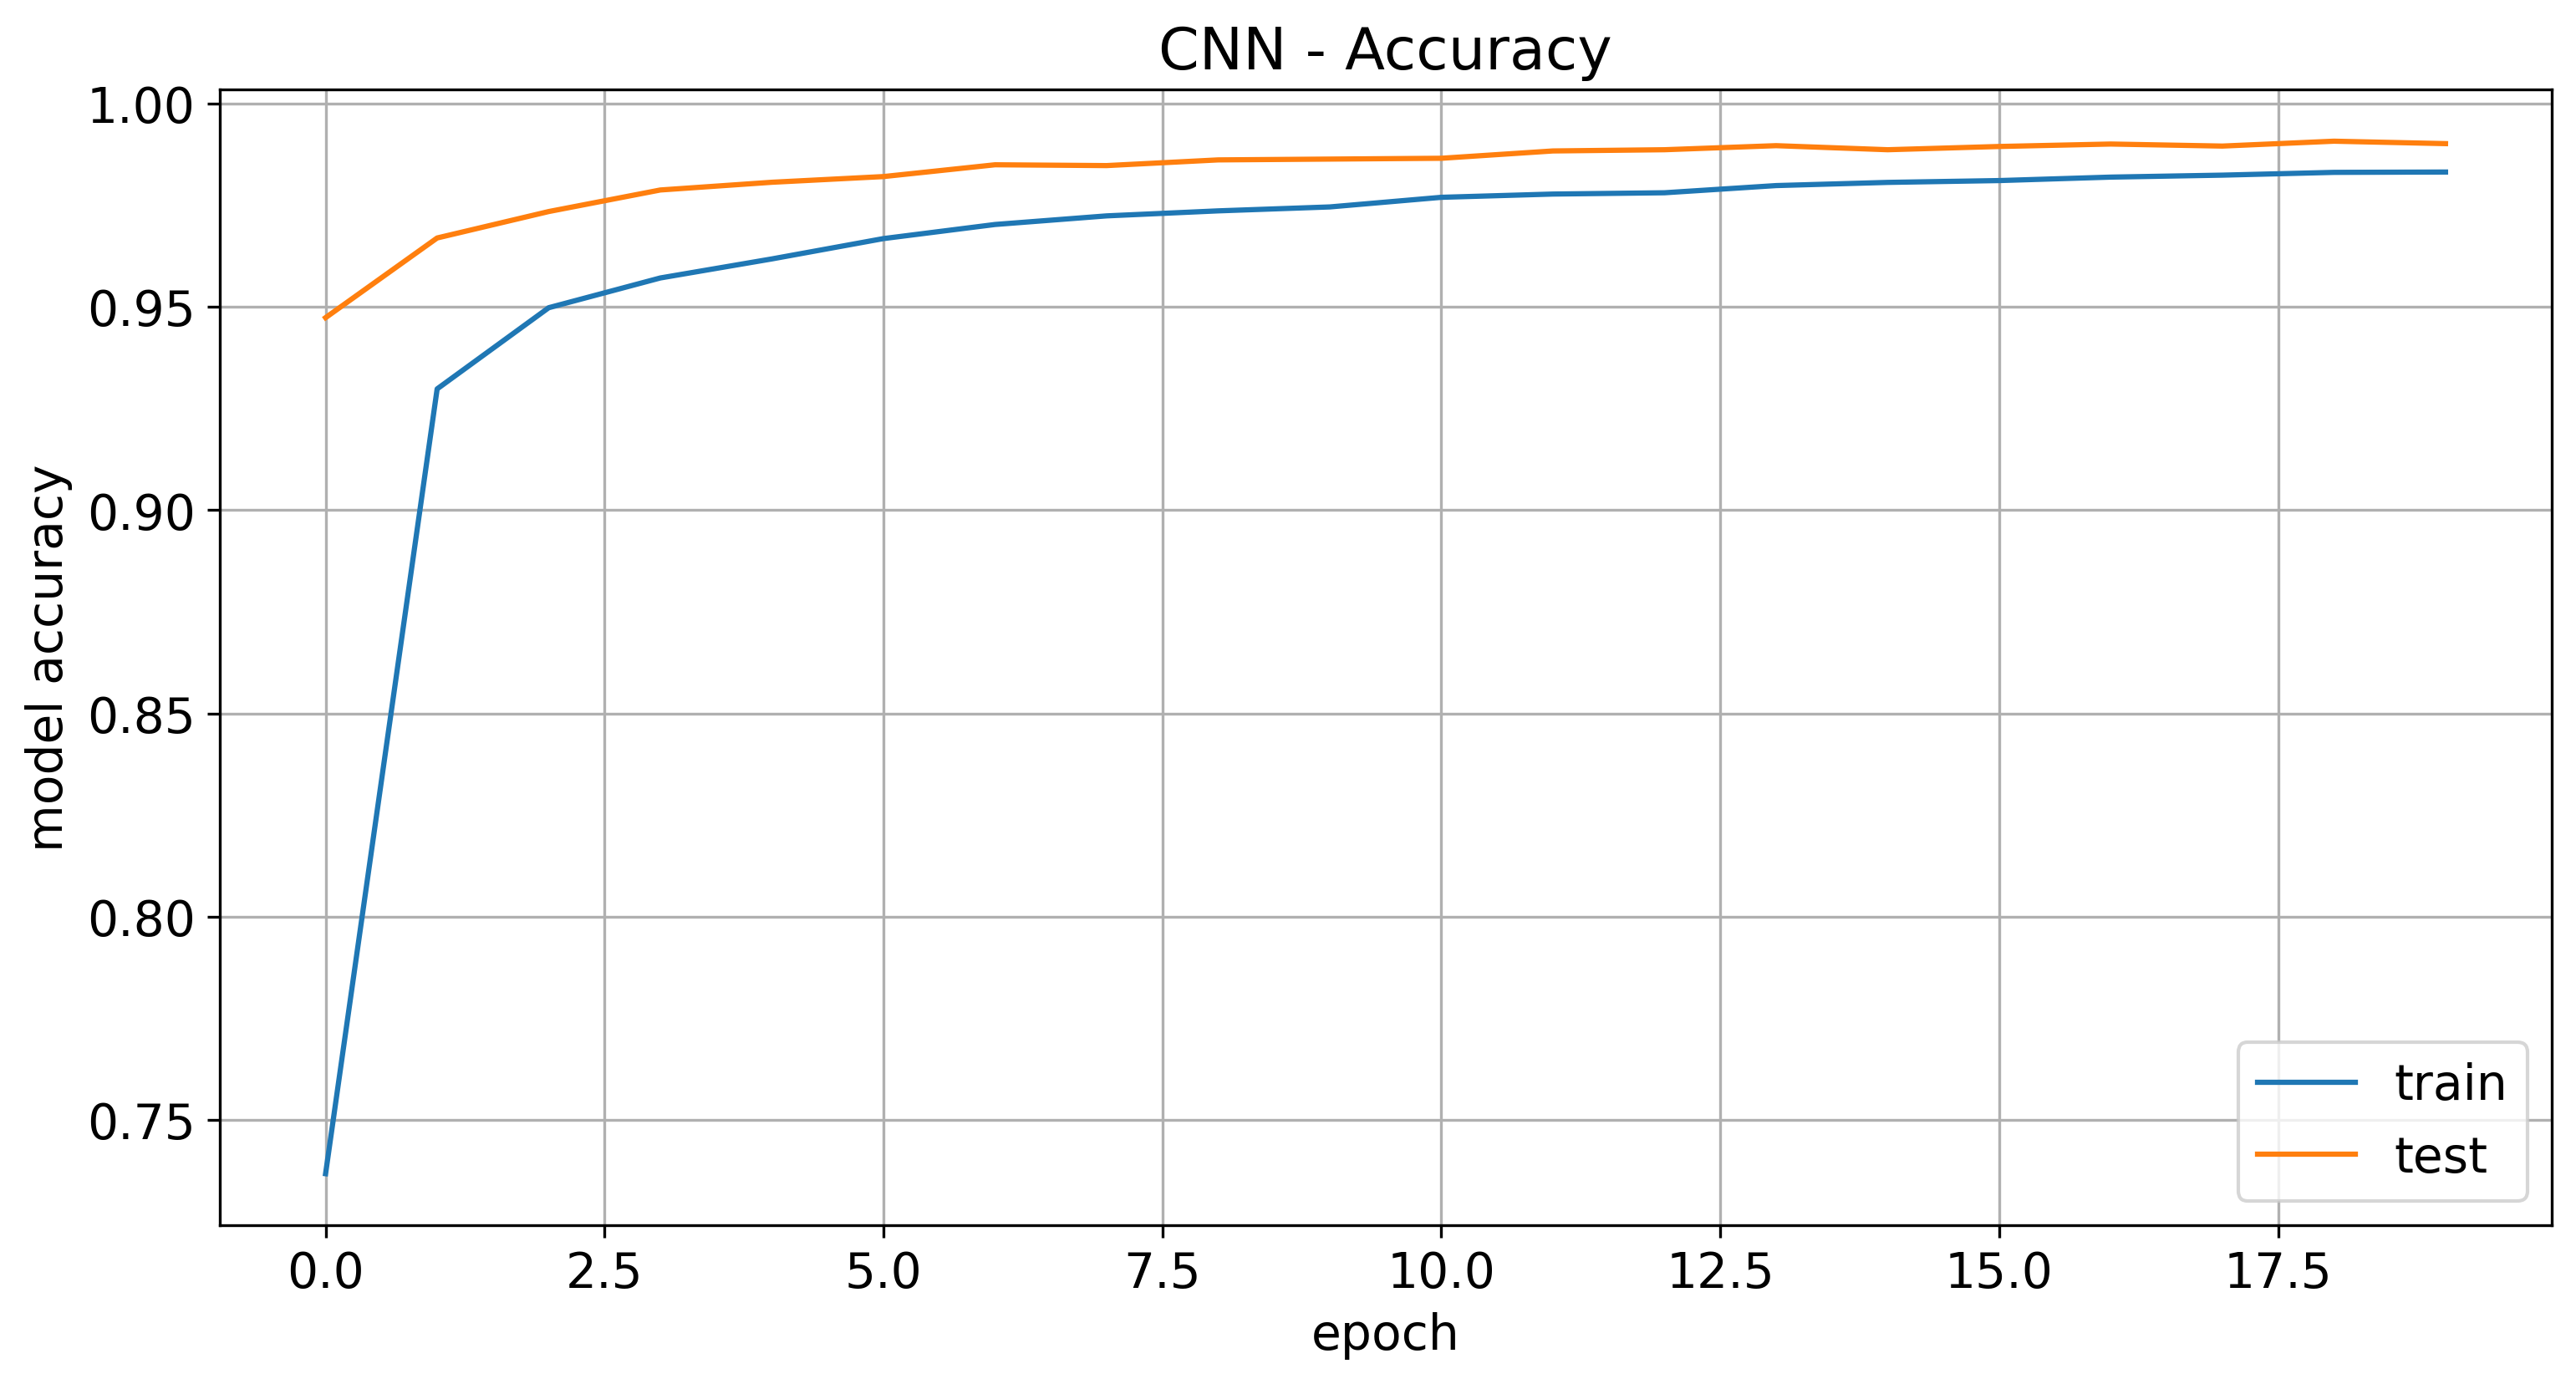

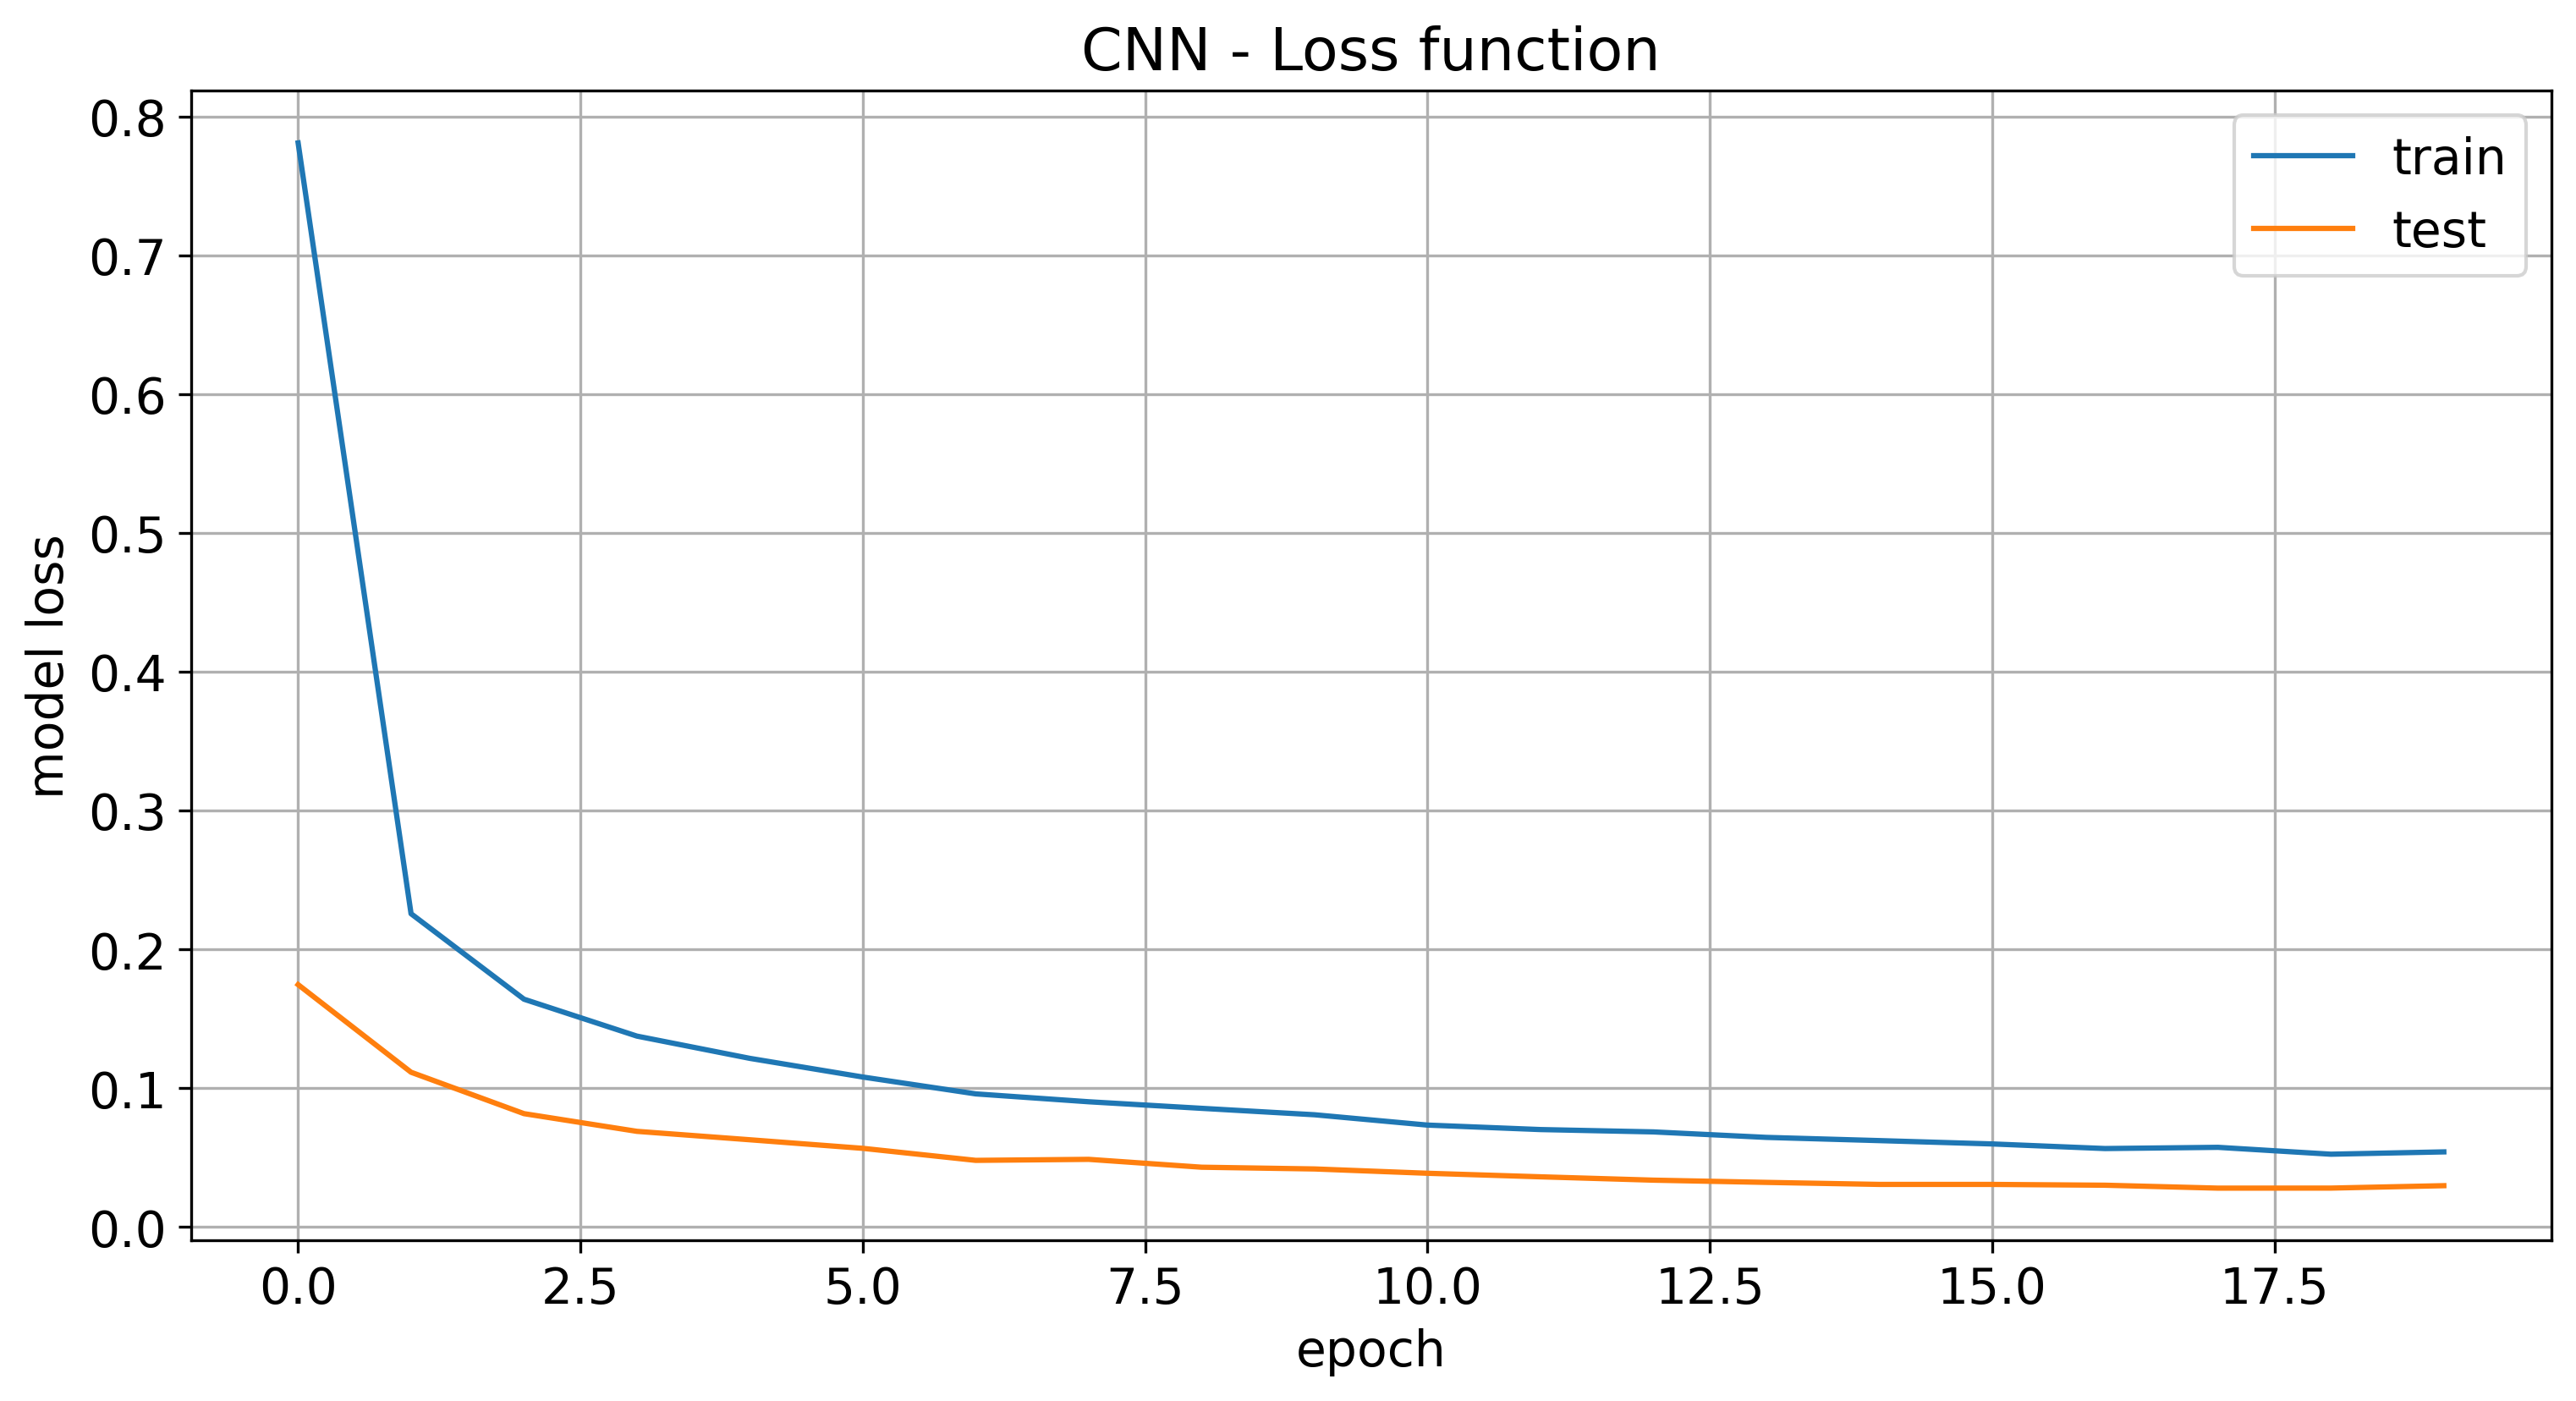

In [39]:
print()
print('Test loss:', score[0])
print('Test accuracy:', score[1])

plt.rcParams.update({'font.size': 14})

plt.subplots(1,1, figsize=(12,6), dpi=300)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.ylabel('model accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.title("CNN - Accuracy")
plt.grid(True)
plt.savefig("./imgs/CNN/CNN_acc.png")
plt.show()

plt.subplots(1,1, figsize=(12,6), dpi=300)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('model loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.title("CNN - Loss function")
plt.grid(True)
plt.savefig("./imgs/CNN/CNN_loss.png")
plt.show()

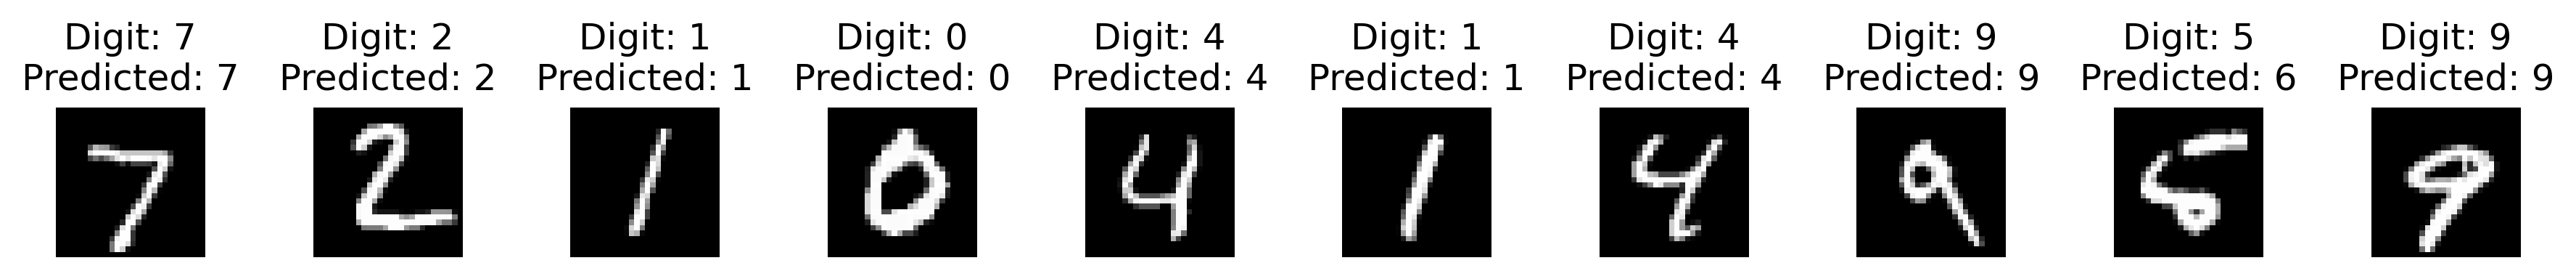

In [40]:
plt.rcParams.update({'font.size': 10})

plt.figure(figsize=(15, 2), dpi=300) 
for i in range(10):    
    ax = plt.subplot(2, 10, i + 1)    
    plt.imshow(X_test[i, :, :, 0], cmap='gray')    
    plt.title("Digit: {}\nPredicted: {}".format(np.argmax(Y_test[i]), np.argmax(predictions[i])))    
    plt.axis('off')
plt.savefig("./imgs/CNN/CNN_samples.png")
plt.show()

### <span style="color:darkblue"> Exercise 12.3 </span>

I wrote by hand the digits from 0 to 9 on gimp and I imported the figures. Here are the results of the classification of my CNN model.

<img src="./imgs/CNN/my_digits.png?version=3">

In [41]:
from PIL import Image
import os

1/1 [==============================] - 0s 16ms/step


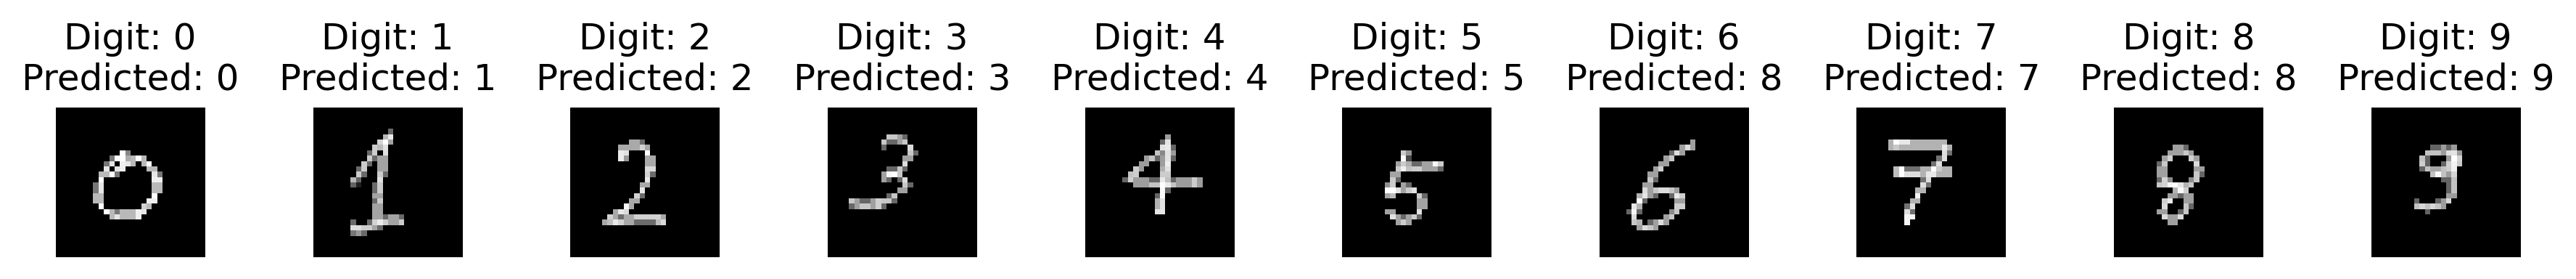

In [42]:
digit_filename = !ls ./imgs/CNN/digit*

plt.rcParams.update({'font.size': 10})
plt.figure(figsize=(15, 2), dpi=300) 

for dig in range(len(digit_filename)):
    digit_in = Image.open(digit_filename[dig]).convert('L')

    ydim, xdim = digit_in.size
    pix=digit_in.load();
    data = np.zeros((xdim, ydim))
    for j in range(ydim):
        for i in range(xdim):
            data[i,j]=pix[j,i]

    data /= 255 
    data = data.reshape(1, xdim, ydim, 1)
    pred_0 = model_CNN.predict(data)
    data = data.reshape(xdim,ydim)
    
    ax = plt.subplot(2, 10, dig+1)  
    plt.title(f"Digit: {dig}\nPredicted: {np.argmax(pred_0)}")
    plt.imshow(data, cmap='gray')
    plt.axis('off')
    
plt.savefig("./imgs/CNN/my_digits.png")
plt.show()